In [1]:
from importlib import reload
from vqe_functions import*
import vqe_functions
from scipy.interpolate import interp2d,CubicSpline,lagrange
import optuna

from qiskit_aer.noise import NoiseModel
from qiskit.utils import algorithm_globals
from qiskit.providers.fake_provider import FakePerth,FakeLagos,FakeNairobi,FakeJakarta
from dataclasses import dataclass
from qiskit.compiler import transpile

/home/alan/anaconda3/envs/quanta/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/alan/anaconda3/envs/quanta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
reload(vqe_functions);

Defining the global 

In [2]:
shots = 2**14

# Anti Parallel Field

## Training

### 4 qubits

In [3]:
graph = get_line_graph(4)
model = 'ap'

Exact results

In [4]:
#values of g
g_exct_values = np.linspace(0.,1.5,100)
g_values = np.linspace(0.,1.6,25)

#exact result
exct_E,exct_m,exct_kk = get_exact_values(graph=graph,g_values=g_exct_values,model=model)


100%|██████████| 100/100 [00:01<00:00, 87.33it/s]


#### Older

In [5]:
#Execution HVA
p_hva = 1
E_4q_p1_bfgs,m_4q_ap_bfgs,kk_4q_ap_bfgs,angles_4q_p1_bfgs = get_vqe_values_ap_hva(graph=graph,
                                                                                  g_values=g_values,
                                                                                  p=p_hva,optimizer=COBYLA(),
                                                                                  shots=shots,reps=5,init_iter=300)

100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


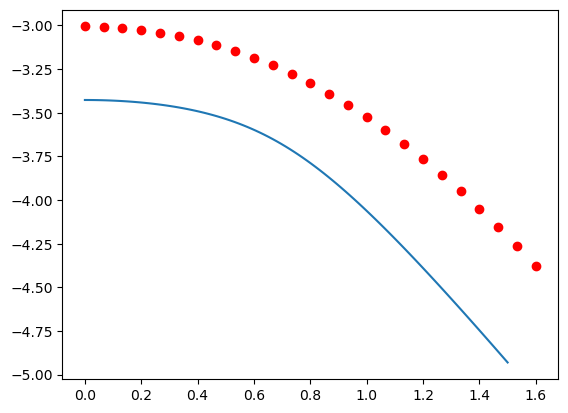

In [6]:
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E)
#plt.plot(g_values,E_tr_4q_cl_cobyla,'ro')
plt.plot(g_values[::-1],E_4q_p1_bfgs,'ro')

In [5]:
#Execution HEA
p_hea = 1
initial_point = np.ones(2*len(graph.nodes)*p_hea)
spsa = SPSA(maxiter=170,trust_region=True,learning_rate=0.085,perturbation=0.1)
spsa_init = SPSA(maxiter=300,trust_region=True,learning_rate=0.1,perturbation=0.1)
E_4q_p1_bfgs,m_4q_ap_bfgs,kk_4q_ap_bfgs,angles_4q_p1_bfgs = get_vqe_values_ap_hea(graph=graph,
                                                                                  g_values=g_values,
                                                                                  p=p_hea,
                                                                                  optimizer=spsa,
                                                                                  initial_point=initial_point,
                                                                                  init_optimizer=spsa_init,
                                                                                  shots=shots,
                                                                                  reps=5)

100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


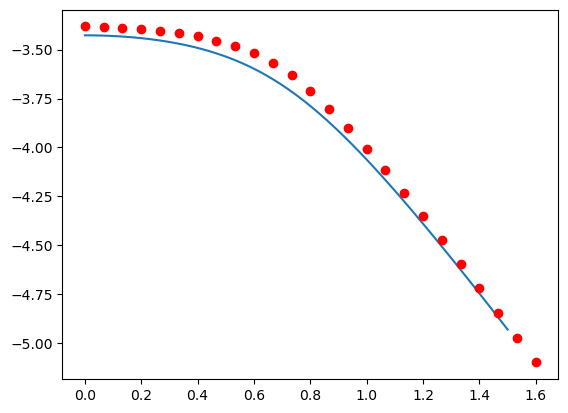

In [6]:
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E)
#plt.plot(g_values,E_tr_4q_cl_cobyla,'ro')
plt.plot(g_values[::-1],E_4q_p1_bfgs,'ro')

#### Phase Diagram

In [5]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='bbe37df5115273fe795d0cab351b2189aa8acd4889b464ccf2c2c8a22223b05a910d88d7294fd067c52e9997b898b88720022b14fdf7efe9ddc8d7c3afaf9ea7'
)
backend = service.backend("ibmq_qasm_simulator")

In [ ]:
# quantum_backend = service.least_busy(operational=True,simulator=False)
# quantum_backend = service.backend("ibm_lagos")

In [11]:
# EXACT OPTIONS
options_exct = Options()
options_exct.execution.shots = shots
options_exct.optimization_level = 1

# QUANTUM BACKEND OPTIONS
options_nairobi = Options()
options_nairobi.execution.shots = 2**14
options_nairobi.optimization_level = 3
options_nairobi.resilience_level = 0

# FAKE DEVICE

fake_nairobi = FakeKolkata()
noise_nairobi = NoiseModel.from_backend(fake_nairobi)
options_noisy_nairobi = Options()
options_noisy_nairobi.execution.shots = shots
options_noisy_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map,
    "seed_simulator": 42
}

options_noisy_nairobi.optimization_level = 3 # no optimization
options_noisy_nairobi.resilience_level = 0 # M3 for Sampler and T-REx for Estimator


# MITIGATED NAIROBI

options_mitigated_nairobi = Options()
options_mitigated_nairobi.execution.shots = shots
options_mitigated_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map
}



# Set number of shots, optimization_level and resilience_level
options_mitigated_nairobi.optimization_level = 3
options_mitigated_nairobi.resilience_level = 1
# options_mitigated_nairobi.resilience.extrapolator = "LinearExtrapolator"
#options_mitigated_nairobi.resilience.noise_factors = [1,2,3]

In [80]:
path_cluster = '/home/alanduriez/qiskit/results/'
path_local = '/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/results/'
path = path_local

In [8]:
# g_values
g_values = np.linspace(0,1.6,30)

# Layers
layers = 1
# Ansatz
ansatz_str='hea'
if ansatz_str=='hea':
    initial_point = np.ones(2*len(graph.nodes)*layers)
elif ansatz_str == 'hva':
    initial_point = np.ones(3*layers)

cobyla = COBYLA(maxiter=2,rhobeg=0.1)
spsa = SPSA(maxiter=129,trust_region=True,learning_rate=0.07,perturbation=0.1)
spsa_init = SPSA(maxiter=230,trust_region=True,learning_rate=0.07,perturbation=0.1)
slqp = SLSQP(100)
init_slqp = SLSQP(200)
bfgs = L_BFGS_B()

optimizer = spsa
init_optimizer = spsa_init

server = 'qasm'

resampling = True
reps = 5

zne = False
extrap = 'lin'

options_exct = Options()
options_exct.execution.shots = shots
options_exct.optimization_level = 3

options_nairobi = Options()
options_nairobi.execution.shots = 2**14
options_nairobi.optimization_level = 3
options_nairobi.resilience_level = 0


E_4q_p1_qasm,angles_4q_p1_qasm = vqe_ap_hea_zne(graph=graph,
                                            g_values=g_values,
                                            ansatz_str=ansatz_str,
                                            layers=layers,
                                            options=options_nairobi,
                                            optimizer=optimizer,
                                            init_optimizer=init_optimizer,
                                            initial_point=initial_point,
                                            service=service,
                                            backend=backend,
                                            server=server,
                                            device_aer=FakeKolkata(),
                                            zne=zne,
                                            shots=shots,
                                            extrap=extrap,
                                            resampling=resampling,
                                            reps=reps,
                                            path=path)


100%|██████████| 30/30 [00:58<00:00,  1.95s/it]


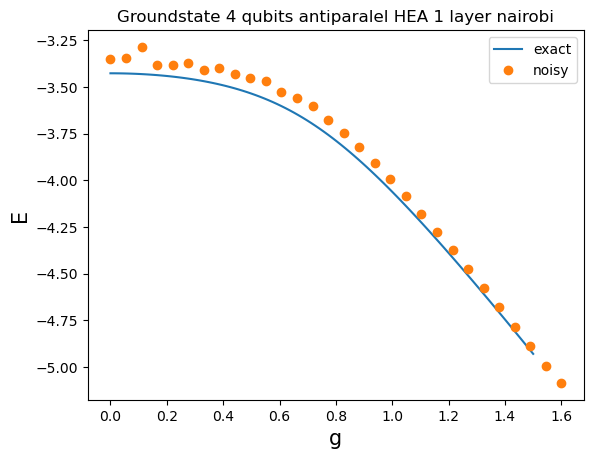

In [9]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E,label='exact')
plt.plot(g_values[::-1],E_4q_p1_qasm,'o',label='noisy')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer nairobi')
plt.legend()
plt.show()

Recycling

In [10]:
spsa = SPSA(maxiter=50,trust_region=True,learning_rate=0.07,perturbation=0.1)
spsa_init = SPSA(maxiter=300,trust_region=True,learning_rate=0.07,perturbation=0.1)

Erec_4q_p1_qasm,anglesrec_4q_p1_qasm = vqe_recycling(graph=graph,
                                            ansatz_str=ansatz_str,
                                            layers=layers,
                                            options=options_nairobi,
                                            angles_opt=angles_4q_p1_qasm,
                                            optimizer=spsa,
                                            service=service,
                                            backend=backend,
                                            server=server,
                                            device_aer=FakeKolkata(),
                                            zne=zne,
                                            shots=shots,
                                            extrap=extrap,
                                            resampling=False,
                                            reps=1,
                                            path=path)


100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


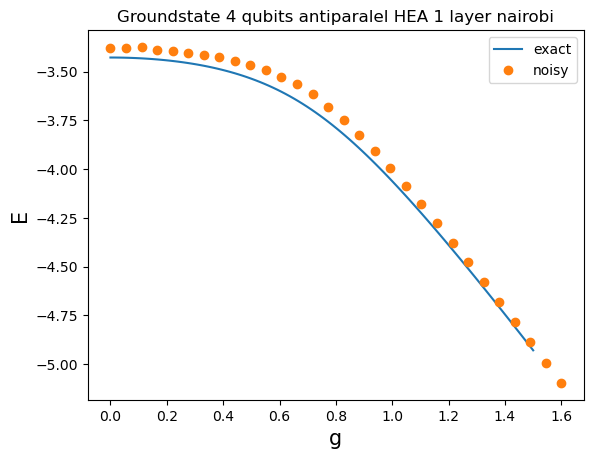

In [11]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E,label='exact')
plt.plot(g_values[::-1],Erec_4q_p1_qasm,'o',label='noisy')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer nairobi')
plt.legend()
plt.show()

In [12]:
def vqe_optimal(graph,
               service,
               backend,
               angles_opt,
               server='qasm',
               device_aer=FakeNairobi(),
               layers=1,
               hx=0.5,
               options=Options(),
               zne=False,
               extrap='lin',
               shots=2**14,
               ansatz_str='hea',
               path=''):
    """Runs the vqe to simulate the antiparallel model in
    the hardware efficient ansatz for different values of
    the antiparallel field"""
    
    n_qubits = len(graph.nodes())
    g_values = [float(k) for k in angles_opt.keys()]
    n_points = len(g_values)
    
    E_values = np.array([0. for i in range(n_points)])
    kk_values = np.array([0. for i in range(n_points)])
    
    # Setting the ansatz
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea_ibm(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ibm_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_antip_ibm(graph,theta_list)
        ansatz_k2 = get_ansatz_antip_ibm(graph,theta_list)
    
    # Getting the list of angles and hamiltonians
    angles_list = []
    h_list = []
    
    kk_op = get_kk_op(graph)
    for g_str,angles in angles_opt.items():
        g = float(g_str)
        h_list.append(get_h_op(graph,hx=hx,ap=g))
        angles_list.append(angles)
   
    
    with Session(service=service,backend=backend) as session:
        estimator = get_estimator(server=server,
                                shots=shots,
                                device_aer=device_aer,
                                session=session,
                                options_rtm=options)
        result_h = estimator.run(n_points*[ansatz],h_list,angles_list).result()
        result_kk = estimator.run(n_points*[ansatz],n_points*[kk_op],angles_list).result()
        if zne == False:
            E_values = result_h.values
            kk_values = result_kk.values
        else:
            result_h_k2 = estimator.run(n_points*[ansatz_k2],h_list,angles_list).result()
            result_kk_k2 = estimator.run(n_points*[ansatz_k2],n_points*[kk_op],angles_list).result()
            for i in range(n_points):
                E_values[i] = get_extrapolation(result_h.values[i],result_h_k2.values[i],extrap)
                kk_values[i] = get_extrapolation(result_kk.values[i],result_kk_k2.values[i],extrap)
        
        session.close()
        
        np.savetxt(path+f'Eopt_{len(graph.nodes)}qubits_{ansatz_str}{layers}_zne_{zne}_{extrap}_{server}.json',E_values)
        np.savetxt(path+f'kkopt_{len(graph.nodes)}qubits_{ansatz_str}{layers}_zne_{zne}_{extrap}_{server}.json',kk_values)



    return E_values,kk_values

In [15]:
E_values_opt_rtm,kk_values_opt_rtm = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 device_aer=FakeKolkata(),
                                 angles_opt=angles_4q_p1_qasm,
                                 options=options_noisy_nairobi,
                                 zne=False,
                                 extrap='exp',
                                 ansatz_str='hea',
                                 path=path,
                                 backend=backend)

E_values_opt_rtm_mit1,kk_values_opt_rtm_mit1 = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 device_aer=FakeKolkata(),
                                 angles_opt=angles_4q_p1_qasm,
                                 options=options_mitigated_nairobi,
                                 zne=False,
                                 extrap='exp',
                                 ansatz_str='hea',
                                 path=path,
                                 backend=backend)

E_values_opt_rtm_mit2,kk_values_opt_rtm_mit2 = vqe_optimal(graph=graph,
                                 service=service,
                                 server='rtm',
                                 device_aer=FakeKolkata(),
                                 angles_opt=angles_4q_p1_qasm,
                                 options=options_mitigated_nairobi,
                                 zne=True,
                                 extrap='exp',
                                 ansatz_str='hea',
                                 path=path,
                                 backend=backend)
E_values_opt_qasm,kk_values_opt_qasm = vqe_optimal(graph=graph,
                                 service=service,
                                 server='qasm',
                                 device_aer=FakeKolkata(),
                                 angles_opt=angles_4q_p1_qasm,
                                 options=options_mitigated_nairobi,
                                 zne=False,
                                 extrap='exp',
                                 ansatz_str='hea',
                                 path=path,
                                 backend=backend)

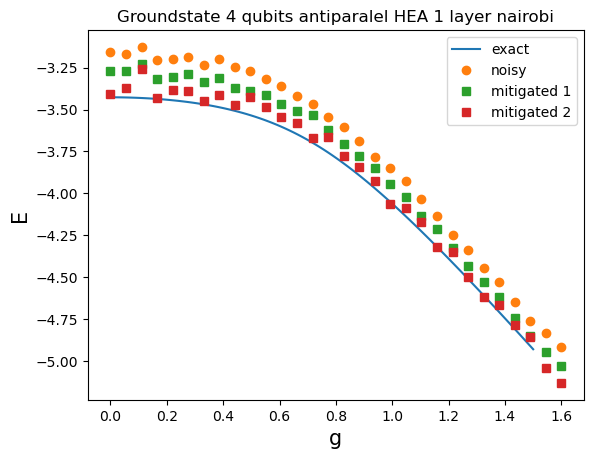

In [16]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E,label='exact')
#plt.plot(g_values[::-1],E_values_opt_qasm,'o',label='noiseless')
plt.plot(g_values[::-1],E_values_opt_rtm,'o',label='noisy')
plt.plot(g_values[::-1],E_values_opt_rtm_mit1,'s',label='mitigated 1')
plt.plot(g_values[::-1],E_values_opt_rtm_mit2,'s',label='mitigated 2')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer nairobi')
plt.legend()
plt.show()

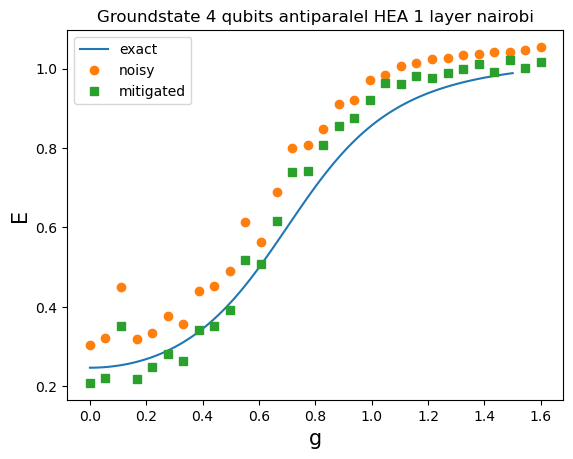

In [17]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_kk,label='exact')
plt.plot(g_values[::-1],kk_values_opt_rtm,'o',label='noisy')
plt.plot(g_values[::-1],kk_values_opt_rtm_mit2,'s',label='mitigated')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer nairobi')
plt.legend()
plt.show()

In [19]:
e_noisy = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_nairobi_noisy.json')
e_zne1 = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_p1_hea_nairobi_lin.json')
e_noiseless = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_nairobi__zne_False_lin_qasm.json')
E_4q_p1_noisy_kolkata_opt = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_kolkata__zne_False_lin_aer.json')
E_4q_p1_znelin_kolkata_opt = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_kolkata__zne_True_lin_aer.json')
E_4q_p1_zneexp_kolkata_opt = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_kolkata__zne_True_exp_aer.json')
E_4q_p1_noise_rtm_kolkata_opt = np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_test_zne_False_none_rtm.json')
E_4q_p1_nairobireal_noisy =  np.loadtxt('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/angles/E_4q_hea1_nairobireal_zne_False_lin_rtm.json')
g_values = np.linspace(0,1.6,25)

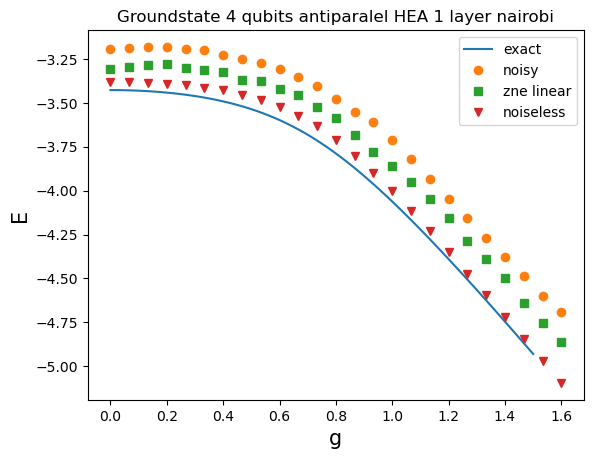

In [20]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E,label='exact')
plt.plot(g_values[::-1],e_noisy,'o',label='noisy')
plt.plot(g_values[::-1],e_zne1,'s',label='zne linear')
plt.plot(g_values[::-1],e_noiseless,'v',label='noiseless')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer nairobi')
plt.legend()
plt.show()

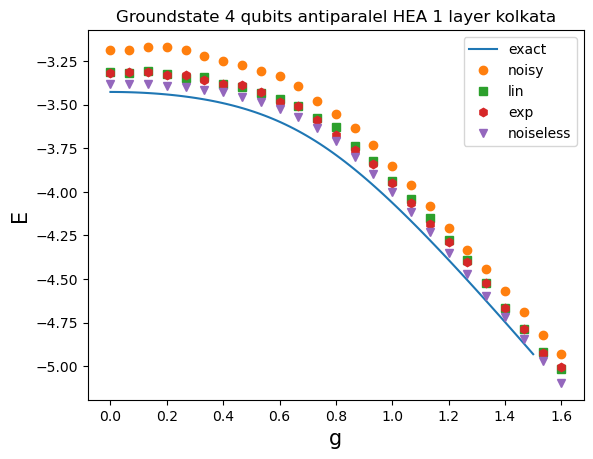

In [21]:
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E,label='exact')
plt.plot(g_values[::-1],E_4q_p1_noisy_kolkata_opt,'o',label='noisy')
plt.plot(g_values[::-1],E_4q_p1_znelin_kolkata_opt,'s',label='lin')
plt.plot(g_values[::-1],E_4q_p1_zneexp_kolkata_opt,'h',label='exp')
plt.plot(g_values[::-1],e_noiseless,'v',label='noiseless')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title('Groundstate 4 qubits antiparalel HEA 1 layer kolkata')
plt.legend()
plt.show()

#### Optimization

In [7]:
n_qubits = 4
graph_8q = get_line_graph(n_qubits)
model = 'ap'
# values for g 
g_exct_values = np.linspace(0.,1.5,50)
g_values = np.linspace(0.,1.6,30)
#exact result
exct_E_8q,exct_m_8q,exct_kk_8q = get_exact_values(graph=graph_8q,g_values=g_exct_values,model=model)

100%|██████████| 50/50 [00:00<00:00, 98.82it/s] 


In [8]:
layers = 1
initial_point = np.ones(2*n_qubits*layers)
random_point = np.random.random(2*n_qubits*layers)
ones_point = np.ones(2*n_qubits*layers)
bfgs = L_BFGS_B()
cobyla = COBYLA(maxiter=800)
spsa = SPSA(maxiter=170,trust_region=True,learning_rate=0.07,perturbation=0.1)
spsa_init = SPSA(maxiter=300,trust_region=True,learning_rate=0.07,perturbation=0.1)
slqp = SLSQP(260)
init_slqp = SLSQP(200)

ansatz_str = 'hea'
optimizer = spsa
init_optimizer = spsa_init

options_nairobi = Options()
options_nairobi.execution.shots = 2**14
options_nairobi.optimization_level = 3
options_nairobi.resilience_level = 0


E_4q_p1_qasm,angles_4q_p1_qasm = vqe_ap_hea_zne(graph=graph_8q,
                                            g_values=g_values,
                                            layers=layers,
                                            options=options_nairobi,
                                            optimizer=optimizer,
                                            init_optimizer=init_optimizer,
                                            initial_point=ones_point,
                                            service=service,
                                            backend=backend,
                                            server='qasm',
                                            device_aer=FakeKolkata(),
                                            zne=False,
                                            resampling=False,
                                            shots=None,
                                            extrap='lin',
                                            reps=4,
                                            ansatz_str=ansatz_str,
                                            )


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


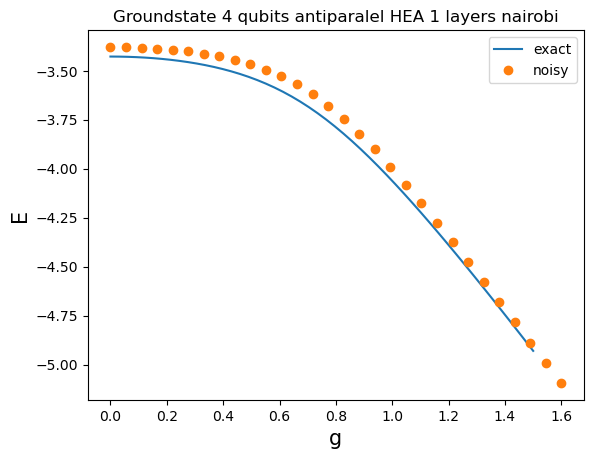

In [9]:
fontsize = 15
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E_8q,label='exact')
plt.plot(g_values[::-1],E_4q_p1_qasm,'o',label='noisy')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.title(f'Groundstate {n_qubits} qubits antiparalel HEA {layers} layers nairobi')
plt.legend()
plt.show()

In [10]:
ap = np.sqrt(0.5)
graph = get_line_graph(n_qubits)


cost_operator = get_h_op(graph,ap=ap,hx=0.5)
mag_op = get_mag_op(graph)
kk_op = get_kk_op(graph)

In [11]:
numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(operator=cost_operator,aux_operators=[mag_op,kk_op])
exact_ec_4q = exact_result.eigenvalue
exact_result.eigenvalue

-3.688399318425179

In [53]:
intermediate_info_1 = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback_1(nfev, parameters, energy, stddev):
    intermediate_info_1['nfev'].append(nfev)
    intermediate_info_1['parameters'].append(parameters)
    intermediate_info_1['energy'].append(energy)
    intermediate_info_1['stddev'].append(stddev)

    
@dataclass
class VQELog_1:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)

In [54]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'step_size': [],
    'step_sucesss': []
}

def callback(nfev, parameters, energy, step_size,step_sucess):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['step_size'].append(step_size)
    intermediate_info['step_sucess'].append(step_sucess)

    
@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, step_size, step_sucess):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)

In [58]:
estimator = Estimator(options={'shots':shots,'seed':170})

layers = 1

ansatz_str = 'hea'
if ansatz_str == 'hea':
    theta_list = ParameterVector('θ',2*n_qubits*layers)
    ansatz = get_ansatz_hea_ibm(graph,theta_list)
    ansatz_k2 = get_ansatz_hea_ibm_ZNE(graph,theta_list)
elif ansatz_str == 'hva':
    theta_list = ParameterVector('θ',3*layers)
    ansatz = get_ansatz_antip_ibm(graph,theta_list)
    ansatz_k2 = get_ansatz_antip_ibm(graph,theta_list)

random_point = np.random.random(ansatz.num_parameters)
ones_point = np.ones(ansatz.num_parameters)

bfgs = L_BFGS_B()
cobyla = COBYLA(100)
# spsa = SPSA(maxiter=170,trust_region=True,learning_rate=0.07,perturbation=0.1,callback=log.update)
slsqp = SLSQP(200)
optimizer = slsqp

server = 'qasm'


resampling = False
reps = 5

zne = False
extrap = 'lin'


# Now we set the cost function, with no mitigation, linear or exp extrapolation
if zne == False:
    def cost_function_vqe(theta):
        job = estimator.run(ansatz, cost_operator, theta)
        values = job.result().values[0]
        return values
if zne == True:
    def cost_function_vqe(theta):
        job = estimator.run([ansatz,ansatz_k2], 2*[cost_operator], 2*[theta])
        value_k1 = job.result().values[0]
        value_k2 = job.result().values[1]
        return get_extrapolation(value_k1=value_k1,value_k2=value_k2,extrap=extrap)              

log_list = []
for i in range(reps):
    log = VQELog([], [])
    spsa = SPSA(maxiter=200,trust_region=True,learning_rate=0.07,perturbation=0.1,callback=log.update)
    random_point = np.random.random(ansatz.num_parameters)
    result_sample = spsa.minimize(cost_function_vqe,x0=random_point)
    log_list.append(log)



In [59]:
mean_list = []
std_list = []
for i in range(len(log_list[0].values)):
    values_list = [log.values[i] for log in log_list]
    mean_list.append(np.mean(values_list))
    std_list.append(np.std(values_list))


0.9522301299670657


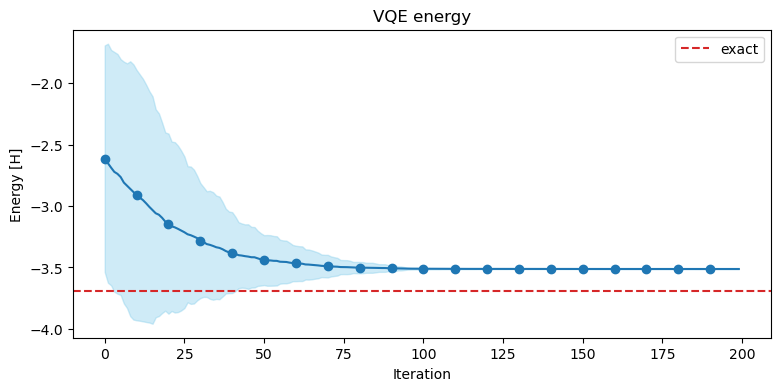

In [60]:
print(mean_list[-1]/exact_result.eigenvalue)
x_values = np.arange(len(mean_list))
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(mean_list,marker='o', linestyle='-',markevery=10)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(mean_list) + 3 * np.array(std_list)  # 3 sigmas
lower_bound = np.array(mean_list) - 3 * np.array(std_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)



plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [81]:
def vqe_critical(graph,
               service,
               backend,
               server='qasm',
               device_aer=FakeNairobi(),
               g=0.7071067811865476,
               layers=1,
               learning_rate=0.07,
               perturbation=0.1,
               maxiter=200,
               hx=0.5,
               options=Options(),
               zne=False,
               extrap='lin',
               reps=1,
               shots=2**14,
               ansatz_str='hea',
               path=''):
    """Runs the vqe to simulate the antiparallel model in
    the hardware efficient ansatz for different values of
    the antiparallel field"""
    
    n_qubits = len(graph.nodes())
    
    if ansatz_str == 'hea':
        theta_list = ParameterVector('θ',2*n_qubits*layers)
        ansatz = get_ansatz_hea_ibm(graph,theta_list)
        ansatz_k2 = get_ansatz_hea_ibm_ZNE(graph,theta_list)
    elif ansatz_str == 'hva':
        theta_list = ParameterVector('θ',3*layers)
        ansatz = get_ansatz_antip_ibm(graph,theta_list)
        ansatz_k2 = get_ansatz_antip_ibm(graph,theta_list)


    cost_operator = get_h_op(graph,hx=hx,ap=g) #Defining Hamiltonian
    
    # Now we set the cost function, with no mitigation, linear or exp extrapolation
    if zne == False:
        def cost_function_vqe(theta):
            job = estimator.run(ansatz, cost_operator, theta)
            values = job.result().values[0]
            return values
    if zne == True:
        def cost_function_vqe(theta):
            job = estimator.run([ansatz,ansatz_k2], 2*[cost_operator], 2*[theta])
            value_k1 = job.result().values[0]
            value_k2 = job.result().values[1]
            return get_extrapolation(value_k1=value_k1,value_k2=value_k2,extrap=extrap)              


    log_list = []
    with Session(service=service,backend=backend) as session:
        estimator = get_estimator(server=server,
                                shots=shots,
                                device_aer=device_aer,
                                session=session,
                                options_rtm=options)
        for i in range(reps):
            log = VQELog([], [])
            spsa = SPSA(maxiter=maxiter,
                        trust_region=True,
                        learning_rate=learning_rate,
                        perturbation=perturbation,
                        callback=log.update)
            random_point = np.random.random(ansatz.num_parameters)
            result_sample = spsa.minimize(cost_function_vqe,x0=random_point)
            log_list.append(log)
        session.close()

    mean_list = []
    std_list = []
    for i in range(len(log_list[0].values)):
        values_list = [log.values[i] for log in log_list]
        mean_list.append(np.mean(values_list))
        std_list.append(np.std(values_list))
    log_list_save = np.array([l.values for l in log_list])
    np.savetxt(path+f'optimization_{len(graph.nodes)}qubits_{ansatz_str}{layers}_zne_{zne}_{extrap}_{server}.json',log_list_save)
    
    return log_list,mean_list,std_list

In [82]:
log_list_qasm,mean_list_qasm,std_list_qasm = vqe_critical(graph=graph_8q,
                                        service=service,
                                        backend=backend,
                                        server='qasm',
                                        device_aer=FakeKolkata(),
                                        g=ap,
                                        layers=layers,
                                        maxiter=250,
                                        ansatz_str=ansatz_str,
                                        reps=reps,
                                        path=path
                                        )

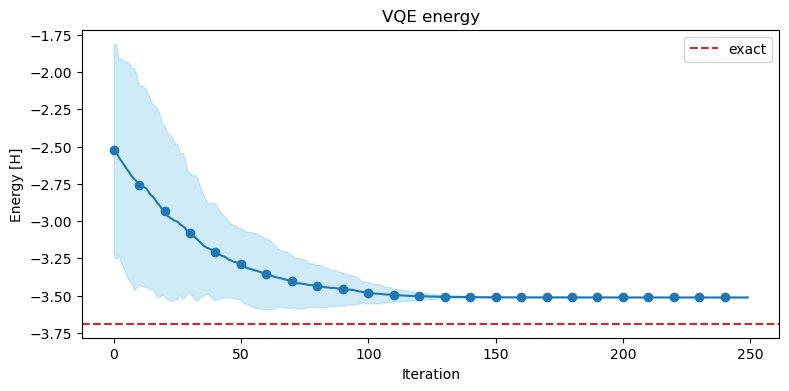

In [84]:
#print(mean_list[-1]/exact_result.eigenvalue)
x_values = np.arange(len(mean_list))
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(mean_list_qasm,marker='o', linestyle='-',markevery=10)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(mean_list_qasm) + 3 * np.array(std_list_qasm)  # 3 sigmas
lower_bound = np.array(mean_list_qasm) - 3 * np.array(std_list_qasm)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)



plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

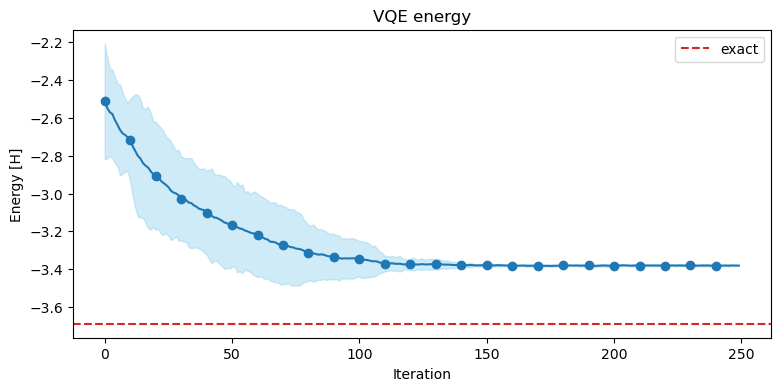

In [78]:
#print(mean_list[-1]/exact_result.eigenvalue)
x_values = np.arange(len(mean_list))
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(mean_list,marker='o', linestyle='-',markevery=10)
# Calculating upper and lower bounds for the confidence interval
upper_bound = np.array(mean_list) + 3 * np.array(std_list)  # 3 sigmas
lower_bound = np.array(mean_list) - 3 * np.array(std_list)  # 3 sigmas
plt.fill_between(x_values, lower_bound, upper_bound, color='skyblue', alpha=0.4)



plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [248]:
-9.299126535866227/exact_result.eigenvalue

0.9716024306369019

In [185]:
opt = log_opt.parameters[-1]
opt

[0.035090572877888804,
 0.4572827078547599,
 0.15814097352246997,
 0.12092144619474665,
 -0.004051052422306398,
 0.08520618719775651,
 0.05915913283773216,
 0.5024682239701719,
 2.875326405779392,
 1.9537979506874286,
 1.104165361967353,
 0.3711462376828134,
 0.24377467369966838,
 0.24683566918501812,
 0.20022027044754187,
 -0.34251625857226425]

In [194]:
log = VQELog([], [])
spsa = SPSA(maxiter=400,trust_region=True,learning_rate=0.01,perturbation=0.07)
vqe = VQE(estimator=estimator,
            ansatz=ansatz_hea,
            optimizer=spsa,
            initial_point=opt,
            callback=log.update)
result_hea = vqe.compute_minimum_eigenvalue(cost_operator)

0.9770542678816441


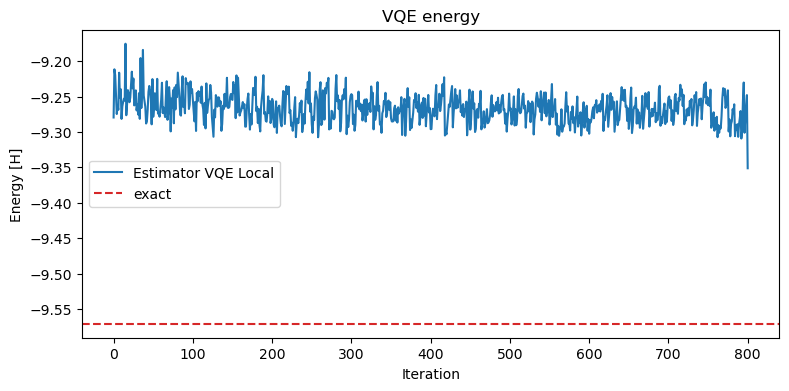

In [195]:
print(result_hea.eigenvalue/exact_result.eigenvalue)
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [97]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.001, 1.0)
    prtb = trial.suggest_float('prtb', 0.001, 1.0)
    spsa = SPSA(maxiter=300,trust_region=True,learning_rate=lr,perturbation=prtb)
    reps = 20
    energy = 0
    for i in tqdm(range(reps)):
        initial_point = np.random.random(ansatz_hea.num_parameters)
        vqe = VQE(estimator=estimator,
                    ansatz=ansatz_hea,
                    optimizer=spsa,
                    initial_point=random_point)
        result_hea = vqe.compute_minimum_eigenvalue(cost_operator)
        if result_hea.eigenvalue < energy:
            energy = result_hea.eigenvalue
        
    return energy
    

In [98]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

[I 2023-10-18 13:22:56,452] A new study created in memory with name: no-name-c3e74140-566b-4c0c-8553-5e2791085f84
100%|██████████| 20/20 [01:37<00:00,  4.90s/it]
[I 2023-10-18 13:24:34,368] Trial 0 finished with value: -3.9794462123461383 and parameters: {'lr': 1.401627142348734, 'prtb': 1.3515429805247687}. Best is trial 0 with value: -3.9794462123461383.
100%|██████████| 20/20 [01:35<00:00,  4.76s/it]
[I 2023-10-18 13:26:09,617] Trial 1 finished with value: -5.688665955506004 and parameters: {'lr': 1.8828520390611498, 'prtb': 1.0239306130538397}. Best is trial 1 with value: -5.688665955506004.
100%|██████████| 20/20 [01:35<00:00,  4.77s/it]
[I 2023-10-18 13:27:45,046] Trial 2 finished with value: -8.944052352638082 and parameters: {'lr': 0.49454715305442004, 'prtb': 0.2131963411158386}. Best is trial 2 with value: -8.944052352638082.
100%|██████████| 20/20 [01:37<00:00,  4.87s/it]
[I 2023-10-18 13:29:22,430] Trial 3 finished with value: -8.517482743392586 and parameters: {'lr': 0.582

In [99]:
study.best_params

{'lr': 0.3351817199154008, 'prtb': 0.3989927706511662}

In [100]:
-9.13231604080937/exact_result.eigenvalue

0.9541735375222752

### Alternative Ansatz (Only two parameters)

In [ ]:
options = Options()

In [ ]:
E_rt,m_rt,kk_rt,angles_rt = get_vqe_values_ap_hva2(graph,g_values,p=4,
                                                   optimizer=L_BFGS_B(),
                                                   reps=5)

100%|██████████| 25/25 [04:21<00:00, 10.48s/it]


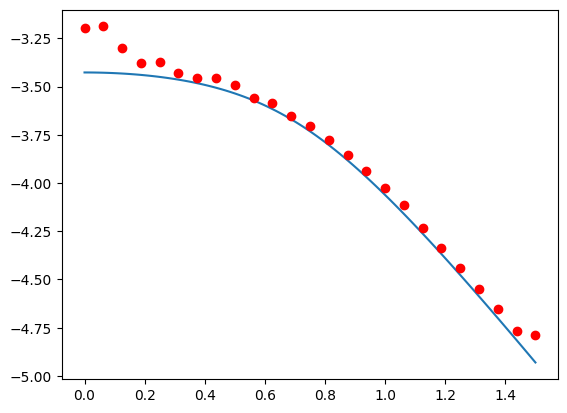

In [ ]:
f,ax = plt.subplots()
plt.plot(g_exct_values,exct_E)
#plt.plot(g_values,E_tr_4q_cl_cobyla,'ro')
plt.plot(g_values[::-1],E_rt,'ro')

## Optimal

### 4 qubits

In [ ]:
graph = get_line_graph(4)
model = 'ap'

#values of g
g_exct_values = np.linspace(0.,1.5,100)
g_values = np.linspace(0.,1.5,25)

#exact result
exct_E,exct_m,exct_kk = get_exact_values(graph=graph,g_values=g_exct_values,model=model)

100%|██████████| 100/100 [00:01<00:00, 94.64it/s]


Getting the parameters

In [ ]:
with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p2.json') as json_file:
    angles_4q_ap_bfgs_p2 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p1.json') as json_file:
    angles_4q_ap_bfgs_p1 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p3.json') as json_file:
    angles_4q_ap_bfgs_p3 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_4q_ap_p4.json') as json_file:
    angles_4q_ap_bfgs_p4 = json.load(json_file)

In [ ]:
# Computing Energies and kinks
shots = 20000
E_4q_p1 = get_E_values_opt(graph,angles_4q_ap_bfgs_p1,shots)
E_4q_p2 = get_E_values_opt(graph,angles_4q_ap_bfgs_p2,shots)
E_4q_p3 = get_E_values_opt(graph,angles_4q_ap_bfgs_p3,shots)
E_4q_p4 = get_E_values_opt(graph,angles_4q_ap_bfgs_p4,shots)
kk_3 = get_kk_values_opt(graph,angles_4q_ap_bfgs_p3,shots)
kk_4 = get_kk_values_opt(graph,angles_4q_ap_bfgs_p4,shots)

In [ ]:
#Exact derivative
dx = np.diff(g_exct_values)
dy = np.diff(exct_E)
de_exct = dy/dx

# Interpolated derivative
E_interp = CubicSpline(g_values,E_4q_p4)
dE_interp = E_interp.derivative()

In [ ]:
# Switching to more sparse points on plot
g = point_corrector(g_values)
E_4q_p1_c = point_corrector(E_4q_p1)
E_4q_p2_c = point_corrector(E_4q_p2)
E_4q_p3_c = point_corrector(E_4q_p3)
E_4q_p4_c = point_corrector(E_4q_p4)
dE_interp_c = point_corrector(dE_interp(g_values))

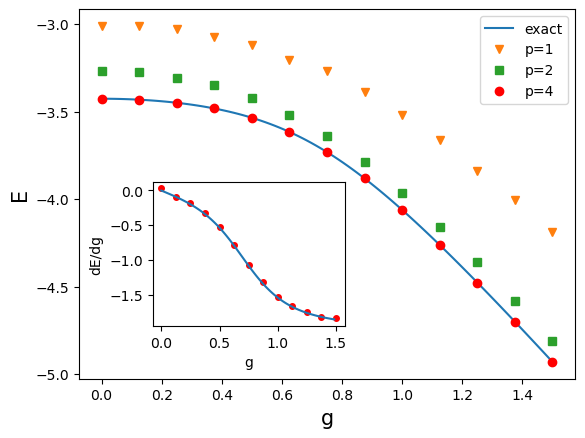

In [ ]:
#Plotting
fontsize = 15
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(g_exct_values,exct_E,label='exact')
plt.plot(g,E_4q_p1_c,'v',label='p=1')
plt.plot(g,E_4q_p2_c,'s',label='p=2')
# plt.plot(g,E_4q_p3_c,'h',label='p=3')
plt.plot(g,E_4q_p4_c,'ro',label='p=4')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
ax.set_xticks([0.2*i for i in range(8)])
ax.set_yticks([(-3.0-0.5*i) for i in range(5)])
#plt.title('Energy Anti-parallel 4 spins')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
inset_ax.plot(g,dE_interp_c,'ro',ms=4.0)
inset_ax.plot(g_exct_values[:-1],de_exct)
inset_ax.set_xlabel('g',fontsize=fontsize-5)
inset_ax.set_ylabel("dE/dg",fontsize=fontsize-5)
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/E_dE_4q.pdf',format='pdf')

IBM runtime

In [ ]:
shots=20000

In [ ]:
#EXACT QASM options
options_exct = Options()
options_exct.execution.shots = shots

In [ ]:
#EXACT QASM 
options_exct = Options()
options_exct.execution.shots = shots

# FAKE KOLKATA
fake_kolkata = FakeKolkata()
noise_kolkata = NoiseModel.from_backend(fake_kolkata)
options_noisy_kolkata = Options()
options_noisy_kolkata.execution.shots = shots
options_noisy_kolkata.simulator = {
    "noise_model": noise_kolkata,
    "basis_gates": fake_kolkata.configuration().basis_gates,
    "coupling_map": fake_kolkata.configuration().coupling_map,
    "seed_simulator": 42
}


options_noisy_kolkata.optimization_level = 0 # no optimization
options_noisy_kolkata.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

# Mitigated Kolkata
options_mitigated_kolkata = Options()
options_mitigated_kolkata.execution.shots = shots
options_mitigated_kolkata.simulator = {
    "noise_model": noise_kolkata,
    "basis_gates": fake_kolkata.configuration().basis_gates,
    "coupling_map": fake_kolkata.configuration().coupling_map,
    "seed_simulator": 42
}


options_mitigated_kolkata.optimization_level = 1 # no optimization
options_mitigated_kolkata.resilience_level = 2 # M3 for Sampler and T-REx for Estimator

# FAKE NAIROBI

fake_nairobi = FakeNairobi()
noise_nairobi = NoiseModel.from_backend(fake_nairobi)
options_noisy_nairobi = Options()
options_noisy_nairobi.execution.shots = shots
options_noisy_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map,
    "seed_simulator": 42
}

options_noisy_nairobi.optimization_level = 0 # no optimization
options_noisy_nairobi.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

# Mitigated Nairobi
options_mitigated_nairobi = Options()
options_mitigated_nairobi.execution.shots
options_mitigated_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map
}

# Set number of shots, optimization_level and resilience_level
options_mitigated_nairobi.optimization_level = 1 # no optimization
options_mitigated_nairobi.resilience_level = 1 # M3 for Sampler and T-REx for Estimator


In [ ]:
# E_p1_noisy_nairobi = get_E_values_opt_ibm(graph,angles_4q_ap_bfgs_p2,options=options_noisy_nairobi)
# E_p1_qasm = get_E_values_opt_ibm(graph,angles_4q_ap_bfgs_p2,options=options_exct)
# E_p1_mitigated_nairobi= get_E_values_opt_ibm(graph,angles_4q_ap_bfgs_p2,options=options_mitigated_nairobi)

In [ ]:
# plt.plot(g_exct_values,exct_E,label='exact')
# plt.plot(g_values,E_p1_qasm,'s',label='qasm')
# plt.plot(g_values,E_p1_noisy_nairobi,'ro',label='noisy')
# plt.plot(g_values,E_p1_mitigated_nairobi,'v',label='mitigated')
# plt.tick_params(axis='both',direction='in') 
# plt.title('Energy 4 qubits p = 1')
# plt.legend()
# plt.show()


Nairobi real hardware

In [ ]:
options_nairobi = options_noisy_perth = Options()
options_nairobi.execution.shots = shots
# Set number of shots, optimization_level and resilience_level
options_nairobi.optimization_level = 1 # no optimization
options_nairobi.resilience_level = 2 # M3 for Sampler and T-REx for Estimator

NameError: name 'Options' is not defined

In [ ]:
#E_p1_mitigated_res2_nairobi = get_E_values_opt_ibm(graph,angles_4q_ap_bfgs_p2,options=options_nairobi,backend_str='ibm_nairobi')

In [ ]:
# np.savetxt('E_p1_mitigated_res2_nairobi.dat',E_p1_mitigated_res2_nairobi)

In [ ]:
# plt.plot(g_exct_values,exct_E,label='exact')
# plt.plot(g_values,E_p1_qasm,'s',label='qasm')
# #plt.plot(g_values,E_p1_noisy_perth,'ro',label='noisy')
# #plt.plot(g_values,E_p1_mitigated_nairobi,'ro',label='mitigated')
# plt.plot(g_values,E_p1_mitigated_res2_nairobi,'h',label='mitigated 2')
# plt.tick_params(axis='both',direction='in') 
# plt.title('Energy 4 qubits p = 2 Nairobi')
# plt.legend()
# plt.show()

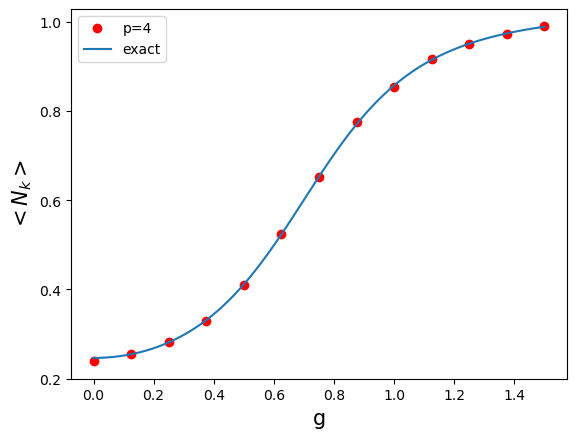

In [ ]:
k_4_c = point_corrector(kk_4)

f,ax = plt.subplots()
#plt.plot(g_values,kk_3,'ro')
plt.plot(g,k_4_c,'ro',label='p=4')
plt.plot(g_exct_values,exct_kk,label='exact')
plt.xlabel('g',fontsize=fontsize)
ax.set_yticks([(0.2+0.2*i) for i in range(5)])
plt.ylabel('$ < N_k > $',fontsize=fontsize)
#plt.title('Kinks Anti-parallel 4 spins')
plt.legend()
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/kk_4q.pdf',format='pdf')

In [ ]:
e_E,e_m,e_kk = get_exact_values(graph=graph,g_values=g_values,model=model)


100%|██████████| 25/25 [00:00<00:00, 92.09it/s]


In [ ]:
devs_4q = get_deviations_layers(e_E,[E_4q_p1,E_4q_p2,E_4q_p3,E_4q_p3])

### 6 qubits AP

In [ ]:
graph_6q_ol = get_line_graph(6)
model = 'ap'

Exact Result

In [ ]:
#values of g
g_exct_values = np.linspace(0.,1.5,100)
g_values = np.linspace(0.,1.5,25)

#exact result
exct_E_6q,exct_m_6q,exct_kk_6q = get_exact_values(graph=graph_6q_ol,g_values=g_exct_values,model=model)


  0%|          | 0/100 [00:00<?, ?it/s]/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/vqe_functions.py:458: ComplexWarning: Casting complex values to real discards the imaginary part
  mag_values[i] = result.aux_operators_evaluated[0][0]
100%|██████████| 100/100 [00:01<00:00, 61.03it/s]


Getting parameters

In [ ]:
with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p1.json') as json_file:
    angles_6q_ap_bfgs_p1 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p2.json') as json_file:
    angles_6q_ap_bfgs_p2 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p3.json') as json_file:
    angles_6q_ap_bfgs_p3 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p4.json') as json_file:
    angles_6q_ap_bfgs_p4 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p5.json') as json_file:
    angles_6q_ap_bfgs_p5 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_6q_ap_p6.json') as json_file:
    angles_6q_ap_bfgs_p6 = json.load(json_file)

Energies

In [ ]:
shots = 2**15
E_6q_p1 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p1,shots)
E_6q_p2 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p2,shots)
E_6q_p3 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p3,shots)
E_6q_p4 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p4,shots)
E_6q_p5 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p5,shots)
E_6q_p6 = get_E_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p6,shots)

kk_6q_p6 = get_kk_values_opt(graph_6q_ol,angles_6q_ap_bfgs_p6,shots)

Derivatives

In [ ]:
#Exact derivative
dx = np.diff(g_exct_values)
dy = np.diff(exct_E_6q)
de_exct_6q = dy/dx

# Interpolated derivative
E_interp = CubicSpline(g_values,E_6q_p6)
dE_interp_6q = E_interp.derivative()

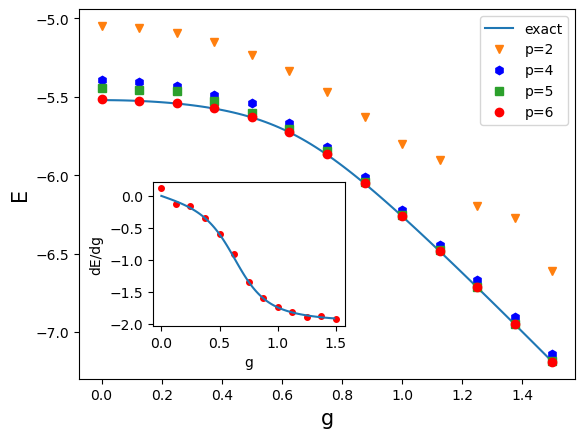

In [ ]:
g = point_corrector(g_values)
E_6q_p1_c = point_corrector(E_6q_p1)
E_6q_p2_c = point_corrector(E_6q_p2)
E_6q_p3_c = point_corrector(E_6q_p3)
E_6q_p4_c = point_corrector(E_6q_p4)
E_6q_p5_c = point_corrector(E_6q_p5)
E_6q_p6_c = point_corrector(E_6q_p6)
dE_interp_6q_c = point_corrector(dE_interp_6q(g_values))



fontsize = 15
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(g_exct_values,exct_E_6q,label='exact')
plt.plot(g,E_6q_p2_c,'v',label='p=2')
plt.plot(g,E_6q_p4_c,'bh',label='p=4')
plt.plot(g,E_6q_p5_c,'s',label='p=5')
plt.plot(g,E_6q_p6_c,'ro',label='p=6')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
#ax.set_xticks([0.2*i for i in range(8)])
#ax.set_yticks([(-3.0-0.5*i) for i in range(5)])
#plt.title('Energy Anti-parallel 6 spins')
plt.legend()
inset_ax = f.add_axes([0.24, 0.22, 0.3, 0.3]) # [left, bottom, width, height]
inset_ax.plot(g,dE_interp_6q_c,'ro',ms=4.0)
inset_ax.plot(g_exct_values[:-1],de_exct_6q)
inset_ax.set_xlabel('g',fontsize=fontsize-5)
inset_ax.set_ylabel("dE/dg",fontsize=fontsize-5)
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/E_dE_6q.pdf',format='pdf')

Kinks

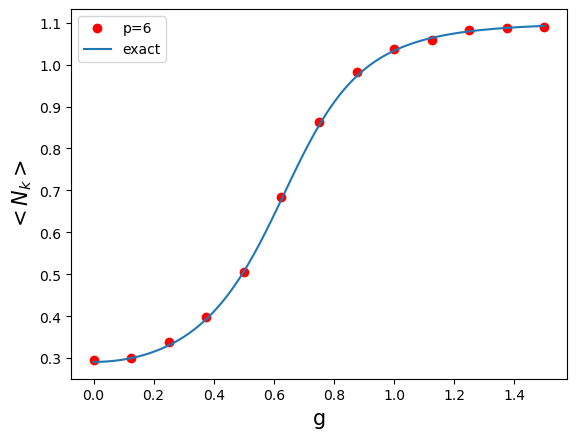

In [ ]:
k_6_c = point_corrector(kk_6q_p6)

f,ax = plt.subplots()
#plt.plot(g_values,kk_3,'ro')
plt.plot(g,k_6_c,'ro',label='p=6')
plt.plot(g_exct_values,exct_kk_6q,label='exact')
plt.xlabel('g',fontsize=fontsize)
#ax.set_yticks([(0.2+0.2*i) for i in range(5)])
plt.ylabel('$<N_k>$',fontsize=fontsize)
#plt.title('Kinks Anti-parallel 6 spins')
plt.legend()
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/kk_6q.pdf',format='pdf')

### 8 qubits AP

In [ ]:
graph_8q_ol = get_line_graph(8)
model = 'ap'

In [ ]:
#values of g
g_exct_values = np.linspace(0.,1.5,100)
g_values = np.linspace(0.,1.5,25)

#exact result
exct_E_8q,exct_m_8q,exct_kk_8q = get_exact_values(graph=graph_8q_ol,g_values=g_exct_values,model=model)


  0%|          | 0/100 [00:00<?, ?it/s]/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/vqe_functions.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  mag_values[i] = result.aux_operators_evaluated[0][0]
100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


Getting parameters

In [ ]:
with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p1.json') as json_file:
    angles_8q_ap_bfgs_p1 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p2.json') as json_file:
    angles_8q_ap_bfgs_p2 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p3.json') as json_file:
    angles_8q_ap_bfgs_p3 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p4.json') as json_file:
    angles_8q_ap_bfgs_p4 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p5.json') as json_file:
    angles_8q_ap_bfgs_p5 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p6.json') as json_file:
    angles_8q_ap_bfgs_p6 = json.load(json_file)


with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p7.json') as json_file:
    angles_8q_ap_bfgs_p7 = json.load(json_file)


with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p8.json') as json_file:
    angles_8q_ap_bfgs_p8 = json.load(json_file)

with open('/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/angles_8q_ap_p9.json') as json_file:
    angles_8q_ap_bfgs_p9 = json.load(json_file)



In [ ]:
shots = 2**15
E_8q_p1 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p1,shots)
E_8q_p2 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p2,shots)
E_8q_p3 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p3,shots)
E_8q_p4 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p4,shots)
E_8q_p5 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p5,shots)
E_8q_p6 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p6,shots)
E_8q_p7 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p6,shots)
E_8q_p8 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p8,shots)
E_8q_p9 = get_E_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p9,shots)


kk_8q_p8 = get_kk_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p8,shots)
kk_8q_p9 = get_kk_values_opt(graph_8q_ol,angles_8q_ap_bfgs_p9,shots)

Derivatives

In [ ]:
#Exact derivative
dx = np.diff(g_exct_values)
dy = np.diff(exct_E_8q)
de_exct_8q = dy/dx

# Interpolated derivative
E_interp = CubicSpline(g_values,E_8q_p8)
dE_interp_8q = E_interp.derivative()

# Interpolated derivative
E_interp = CubicSpline(g_values,E_8q_p9)
dE_interp_9q = E_interp.derivative()

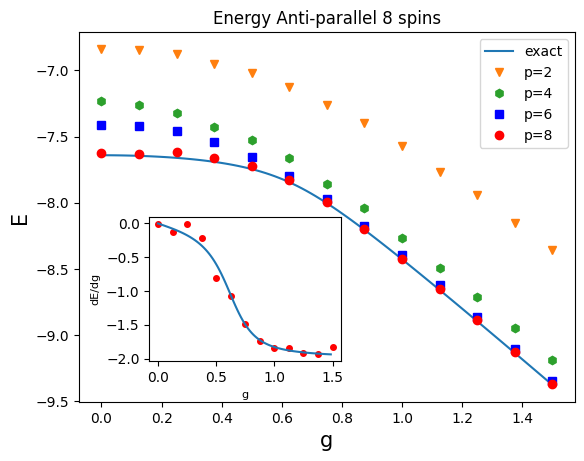

In [ ]:
g = point_corrector(g_values)
E_8q_p2_c = point_corrector(E_8q_p2)
E_8q_p4_c = point_corrector(E_8q_p4)
E_8q_p6_c = point_corrector(E_8q_p6)
E_8q_p8_c = point_corrector(E_8q_p8)
dE_interp_8q_c = point_corrector(dE_interp_8q(g_values))



fontsize = 15
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(g_exct_values,exct_E_8q,label='exact')
plt.plot(g,E_8q_p2_c,'v',label='p=2')
plt.plot(g,E_8q_p4_c,'h',label='p=4')
plt.plot(g,E_8q_p6_c,'bs',label='p=6')
plt.plot(g,E_8q_p8_c,'ro',label='p=8')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
#ax.set_xticks([0.2*i for i in range(8)])
#ax.set_yticks([(-3.0-0.5*i) for i in range(5)])
plt.title('Energy Anti-parallel 8 spins')
plt.legend()
inset_ax = f.add_axes([0.235, 0.195, 0.3, 0.3]) # [left, bottom, width, height]
inset_ax.plot(g,dE_interp_8q_c,'ro',ms=4.0)
inset_ax.plot(g_exct_values[:-1],de_exct_8q)
inset_ax.set_xlabel('g',fontsize=fontsize-7)
inset_ax.set_ylabel("dE/dg",fontsize=fontsize-7)
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/E_dE_8q.pdf',format='pdf')

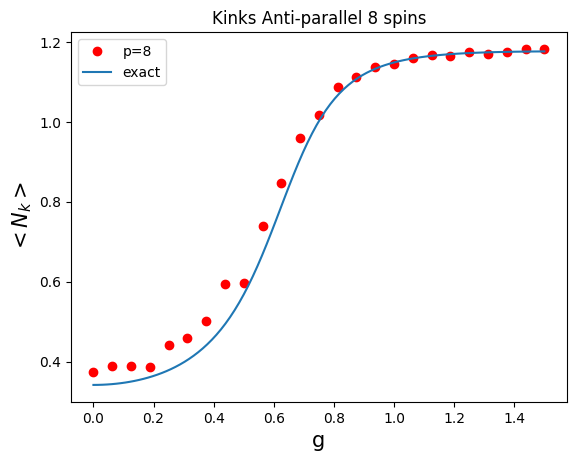

In [ ]:
kk_8q_c = point_corrector(kk_8q_p8)

f,ax = plt.subplots()
#plt.plot(g_values,kk_3,'ro')
plt.plot(g_values,kk_8q_p8,'ro',label='p=8')
plt.plot(g_exct_values,exct_kk_8q,label='exact')
plt.xlabel('g',fontsize=fontsize)
#ax.set_yticks([(0.2+0.2*i) for i in range(5)])
plt.ylabel('$<N_k>$',fontsize=fontsize)
plt.title('Kinks Anti-parallel 8 spins')
plt.legend()
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/kk_8q.pdf',format='pdf')

Testing the 9 layer 

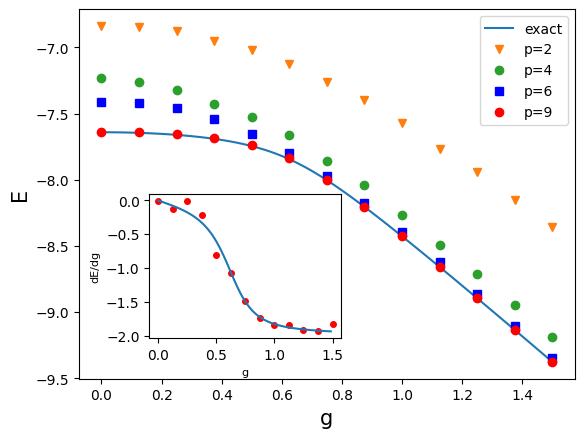

In [ ]:
g = point_corrector(g_values)
E_8q_p2_c = point_corrector(E_8q_p2)
E_8q_p4_c = point_corrector(E_8q_p4)
E_8q_p6_c = point_corrector(E_8q_p6)
E_8q_p9_c = point_corrector(E_8q_p9)
dE_interp_9q_c = point_corrector(dE_interp_9q(g_values))



fontsize = 15
f,ax = plt.subplots()
#plt.plot(g_values,E_3,'ro')
plt.plot(g_exct_values,exct_E_8q,label='exact')
plt.plot(g,E_8q_p2_c,'v',label='p=2')
plt.plot(g,E_8q_p4_c,'o',label='p=4')
plt.plot(g,E_8q_p6_c,'bs',label='p=6')
plt.plot(g,E_8q_p9_c,'ro',label='p=9')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
#ax.set_xticks([0.2*i for i in range(8)])
#ax.set_yticks([(-3.0-0.5*i) for i in range(5)])
#plt.title('Energy Anti-parallel 8 spins')
plt.legend()
inset_ax = f.add_axes([0.235, 0.195, 0.3, 0.3]) # [left, bottom, width, height]
inset_ax.plot(g,dE_interp_8q_c,'ro',ms=4.0)
inset_ax.plot(g_exct_values[:-1],de_exct_8q)
inset_ax.set_xlabel('g',fontsize=fontsize-7)
inset_ax.set_ylabel("dE/dg",fontsize=fontsize-7)
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/E_dE_8q.pdf',format='pdf')

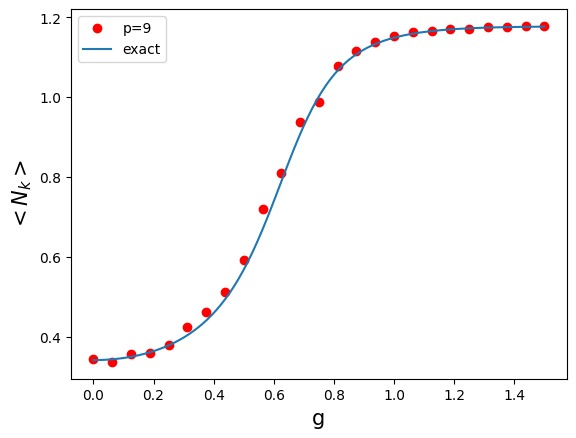

In [ ]:
kk_9q_c = point_corrector(kk_8q_p9)

f,ax = plt.subplots()
#plt.plot(g_values,kk_3,'ro')
plt.plot(g_values,kk_8q_p9,'ro',label='p=9')
plt.plot(g_exct_values,exct_kk_8q,label='exact')
plt.xlabel('g',fontsize=fontsize)
#ax.set_yticks([(0.2+0.2*i) for i in range(5)])
plt.ylabel('$<N_k>$',fontsize=fontsize)
#plt.title('Kinks Anti-parallel 8 spins')
plt.legend()
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/kk_8q.pdf',format='pdf')

Error graph

In [ ]:
e_4q,e_m,e_kk = get_exact_values(graph=graph,g_values=g_values,model=model)

e_6q,e_m,e_kk = get_exact_values(graph=graph_6q_ol,g_values=g_values,model=model)

e_8q,e_m,e_kk = get_exact_values(graph=graph_8q_ol,g_values=g_values,model=model)


  0%|          | 0/25 [00:00<?, ?it/s]/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/vqe_functions.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  mag_values[i] = result.aux_operators_evaluated[0][0]
100%|██████████| 25/25 [00:01<00:00, 23.07it/s]


In [ ]:
devs_4q = get_deviations_layers(e_4q,[E_4q_p1,E_4q_p2,E_4q_p3,E_4q_p4])

devs_6q = get_deviations_layers(e_6q,[E_6q_p1,E_6q_p2,E_6q_p3,E_6q_p4,E_6q_p5,E_6q_p6])

devs_8q = get_deviations_layers(e_8q,[E_8q_p1,
                                      E_8q_p2,
                                      E_8q_p3,
                                      E_8q_p4,
                                      E_8q_p6,
                                      E_8q_p8,
                                      ])

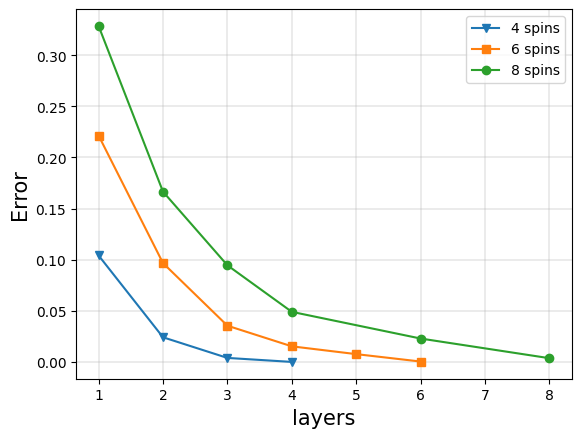

In [ ]:
f,ax = plt.subplots()
plt.plot([1,2,3,4],devs_4q,marker='v',label='4 spins')
plt.plot([1,2,3,4,5,6],devs_6q,marker='s',label='6 spins')
plt.plot([1,2,3,4,6,8],devs_8q,marker='o',label='8 spins')
#plt.title('Deviation from exact values')
plt.xlabel('layers',fontsize=fontsize)
plt.ylabel('Error',fontsize=fontsize)
plt.legend()
plt.grid(True,linewidth=0.35)
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/Error_plot.png',format='png')


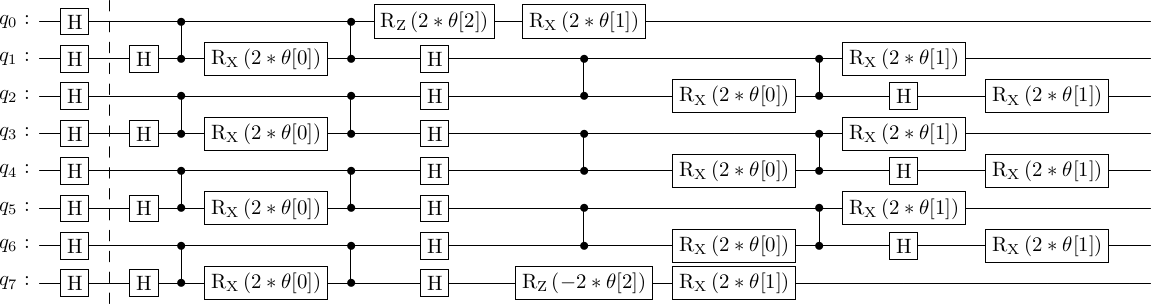

In [ ]:
graph = get_line_graph(8)
theta_list = ParameterVector('θ',3)
qc = get_ansatz_antiparallel(graph,theta_list)
qc.draw('latex',
        vertical_compression='low',
        fold=65)

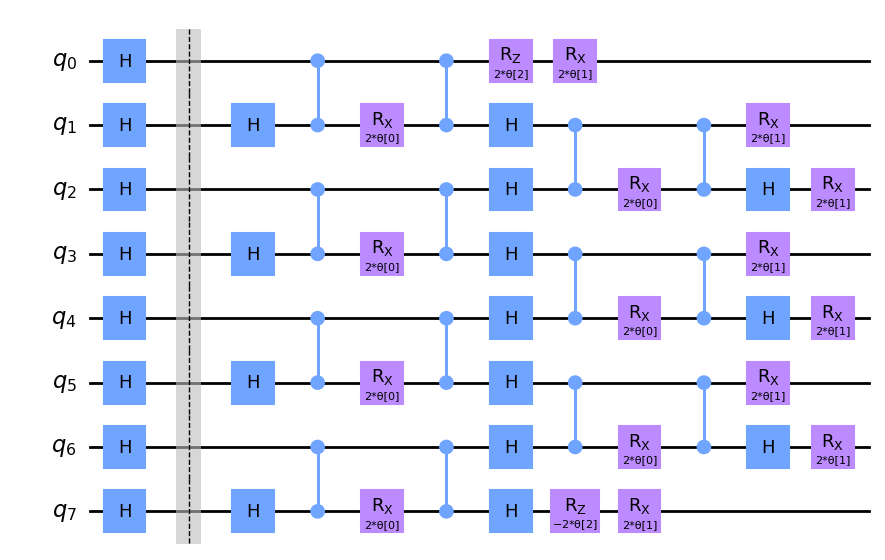

In [ ]:
graph = get_line_graph(8)
theta_list = ParameterVector('θ',3)
qc = get_ansatz_antiparallel(graph,theta_list)
qc.draw('mpl',
        vertical_compression='low',
        fold=65)

In [ ]:
edges = [edge for edge in graph.edges()]
for edge in graph.edges():
    if edge[0]%2==0:
        print(edge)

(0, 1)
(2, 3)
(4, 5)
(6, 7)


In [ ]:
edges = [edge for edge in graph.edges()]
even_edges = [edge for edge in graph.edges() if edge[0]%2==0]
odd_edges = [edge for edge in graph.edges() if edge[0]%2!=0]
odd_edges

[(1, 2), (3, 4), (5, 6)]

graph

# Transverse Field

## Max Cut Trotterization

In [5]:
graph_chain = get_chain_graph(4)

In [6]:
p = 2
theta_list_tf = ParameterVector('theta',2*p)
ansatz_transverse = get_ansatz_transverse(graph_chain,theta_list_tf)
cost_operator_maxcut = get_h_op(graph_chain,hx=0.)
estimator = Estimator(options={'shots':2*15,'seed':170})
initial_point = np.random.random(ansatz_transverse.num_parameters)

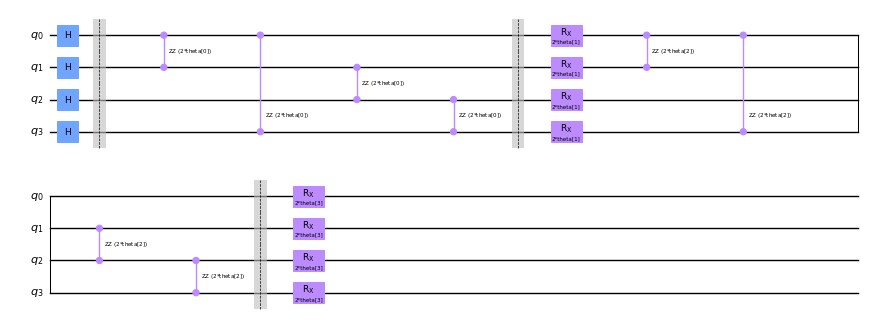

In [7]:
ansatz_transverse.draw('mpl',scale=0.5)

In [8]:
E_tf_exct = get_result(graph_chain,method='EXACT',hx=0.)
E_tf_exct.eigenvalue

(-4+0j)

In [9]:
vqe = VQE(estimator,ansatz_transverse,COBYLA())
result = vqe.compute_minimum_eigenvalue(cost_operator_maxcut)

In [10]:
result.eigenvalue

-4.004379055868916

In [11]:
def get_trotter_maxcut(graph,steps=5,dt=1e-2):
    
    n_qubits = len(graph.nodes)
    trotter_circ = QuantumCircuit(n_qubits)
    
    #initial state
    trotter_circ.h(range(n_qubits))

    for step in range(steps):
        x_angle = -2*(1-step/steps)*dt
        z_angle = -2*(step/steps)*dt
        # interaction hamiltonian
        for pair in graph.edges:
            trotter_circ.rzz(z_angle,pair[0],pair[1])
        # mixing
        trotter_circ.rx(x_angle,range(n_qubits))


    return trotter_circ



In [12]:
dt = 1e-2
steps = 5000
dt*steps

50.0

In [13]:
trotter_circ = get_trotter_maxcut(graph_chain,steps=steps,dt=dt)
shots = 2**15
estimator = Estimator(options={'shots':shots,'seed':170})
#trotter_circ.draw('mpl')
result_trotter = estimator.run(trotter_circ,cost_operator_maxcut).result()

In [14]:
result_trotter.values

array([-3.99999655])

In [15]:
eigenvalues = np.linalg.eigvals(cost_operator_maxcut.to_matrix())

In [16]:
np.sort(eigenvalues)

array([-4.+0.j, -4.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
        4.+0.j,  4.+0.j])

## Transverse field Trotter

In [17]:
cost_operator_transverse = get_h_op(get_chain_graph(4),hx=0.5).simplify()

In [18]:
numpy_solver = NumPyMinimumEigensolver()
exct_E_tr = numpy_solver.compute_minimum_eigenvalue(cost_operator_transverse)
exct_E_tr.eigenvalue

-4.271558410139715

In [19]:
vqe = VQE(estimator,ansatz_transverse,optimizer=COBYLA())
result = vqe.compute_minimum_eigenvalue(cost_operator_transverse)


In [20]:
result.eigenvalue


-4.271563922539811

In [21]:
eigenvalues = np.linalg.eigvals(cost_operator_transverse.to_matrix())

In [22]:
np.sort(eigenvalues)[0]

(-4.271558410139714+0j)

In [ ]:
# eigenvalues_ap = np.linalg.eigvals(cost_operator.to_matrix())
# np.sort(eigenvalues_ap)

In [23]:
def get_trotter_transverse(graph,h=0.5,steps=5,dt=1e-2):
    
    n_qubits = len(graph.nodes)
    trotter_circ = QuantumCircuit(n_qubits)
    circ_list = []
    
    #initial state
    trotter_circ.h(range(n_qubits))

    for step in range(steps):
        x_angle = -2*(1-step/steps)*dt
        z_angle = -2*(step/steps)*dt
        # interaction hamiltonian
        for pair in graph.edges:
            trotter_circ.rzz(z_angle,pair[0],pair[1])
        # transverse field 
        # trotter_circ.rx(z_angle*h,range(n_qubits))
        # mixing
        trotter_circ.rx(x_angle+z_angle*h,range(n_qubits))
        circ_list.append(trotter_circ.copy())


    return circ_list


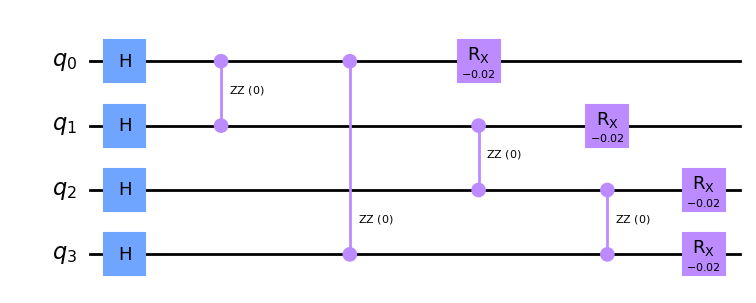

In [24]:
get_trotter_transverse(graph_chain,steps=1)[0].draw('mpl')

In [55]:
dt = 2e-2
steps = 250
dt*steps
T = dt*steps
T

5.0

In [56]:
shots = 2**15
estimator = Estimator(options={'shots':shots,'seed':120})
trotter_circ_transverse = get_trotter_transverse(graph_chain,steps=steps,dt=dt)[-2]
#trotter_circ.draw('mpl')
result_trotter_transverse = estimator.run(trotter_circ_transverse,cost_operator_transverse).result()


In [57]:

result_trotter_transverse.values

array([-4.26551442])

In [58]:
time_instants = np.linspace(dt,steps*dt,steps)
H_d = get_h_op(graph_chain,hx=1,J=0).simplify()
H_p = cost_operator_transverse

#making the time-depedent hamiltonian
H_t = []
for t in time_instants:
    H_t.append((1-t/T)*H_d+(t/T)*H_p)

In [59]:
steps_circuits = get_trotter_transverse(graph_chain,steps=steps,dt=dt)
trotter_ev = estimator.run(steps_circuits,H_t).result()

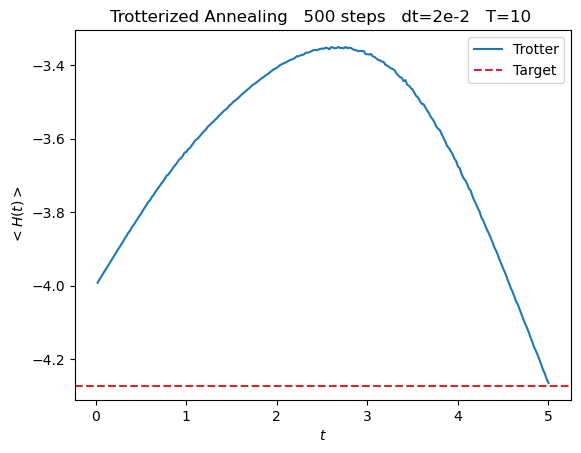

In [60]:
plt.plot(time_instants,trotter_ev.values,label='Trotter')
plt.axhline(y=exct_E_tr.eigenvalue, color="tab:red", ls="--", label="Target")
plt.title('Trotterized Annealing   500 steps   dt=2e-2   T=10 ')
plt.ylabel("$< H(t) >$")
plt.xlabel("$t$")
plt.legend(loc="best")

In [82]:
def lambda_t(t,tau):
    return np.sin((np.pi/2)*np.sin(np.pi*t/(2*tau))**2)**2

In [81]:
def get_trotter_transverse_2(graph,h=0.5,steps=5,dt=1e-2):
    
    n_qubits = len(graph.nodes)
    trotter_circ = QuantumCircuit(n_qubits)
    circ_list = []
    tau = dt*steps
    
    #initial state
    trotter_circ.h(range(n_qubits))

    for step in range(steps):
        x_angle = -2*(1-lambda_t(step*dt,tau))*dt
        z_angle = -2*lambda_t(step*dt,tau)*dt
        # interaction hamiltonian
        for pair in graph.edges:
            trotter_circ.rzz(z_angle,pair[0],pair[1])
        # transverse field 
        # trotter_circ.rx(z_angle*h,range(n_qubits))
        # mixing
        trotter_circ.rx(x_angle+z_angle*h,range(n_qubits))
        circ_list.append(trotter_circ.copy())


    return circ_list

In [111]:
steps = 250
dt = 2e-2
shots = 2**15
estimator = Estimator(options={'shots':shots,'seed':120})
trotter_circ_transverse = get_trotter_transverse_2(graph_chain,steps=steps,dt=dt)[-1]
#trotter_circ.draw('mpl')
result_trotter_transverse = estimator.run(trotter_circ_transverse,cost_operator_transverse).result()


In [112]:
result_trotter_transverse.values

array([-3.93757207])

In [113]:
time_instants = np.linspace(dt,steps*dt,steps)
H_d = get_h_op(graph_chain,hx=1,J=0).simplify()
H_p = cost_operator_transverse

#making the time-depedent hamiltonian
H_t = []
for t in time_instants:
    H_t.append((1-lambda_t(t,steps*dt))*H_d+lambda_t(t,steps*dt)*H_p)

steps_circuits = get_trotter_transverse(graph_chain,steps=steps,dt=dt)
trotter_ev = estimator.run(steps_circuits,H_t).result()

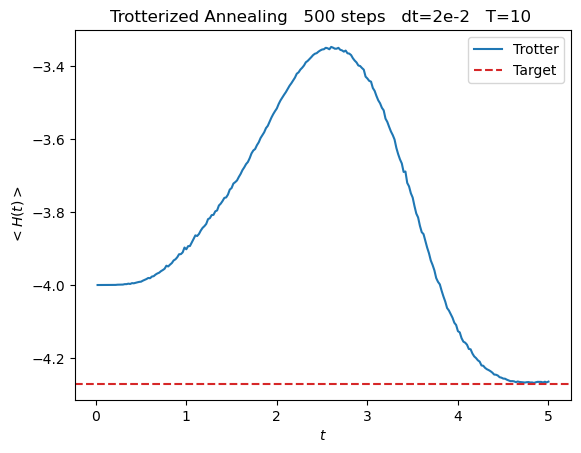

In [115]:
plt.plot(time_instants,trotter_ev.values,label='Trotter')
plt.axhline(y=exct_E_tr.eigenvalue, color="tab:red", ls="--", label="Target")
plt.title('Trotterized Annealing   500 steps   dt=2e-2   T=10 ')
plt.ylabel("$< H(t) >$")
plt.xlabel("$t$")
plt.legend(loc="best")

# Analizing the crittical point

## Options

In [67]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

    
@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)

In [68]:
n_qubits = 4
p = 1
p_hea = 1
ap = g_values[-1]
graph = get_line_graph(n_qubits)


cost_operator = get_h_op(graph,ap=ap,hx=0.5)
mag_op = get_mag_op(graph)
kk_op = get_kk_op(graph)
aux_operators = [mag_op,kk_op]

Exact

In [69]:
numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(operator=cost_operator,aux_operators=[mag_op,kk_op])
exact_ec_4q = exact_result.eigenvalue
exact_result.eigenvalue

-5.117264222069958

Primitives

In [70]:
estimator = Estimator(options={'shots':shots,'seed':170})
seed = 170
# AER
aer_estimator = AerEstimator(
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed}
)


OPTIONS

In [71]:
# EXACT 

options_exct = Options()
options_exct.execution.shots = shots
options_exct.optimization_level = 3


# FAKE NAIROBI

fake_nairobi = FakeNairobi()
noise_nairobi = NoiseModel.from_backend(fake_nairobi)
options_noisy_nairobi = Options()
options_noisy_nairobi.execution.shots = shots
options_noisy_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map,
    "seed_simulator": 42
}

options_noisy_nairobi.optimization_level = 0 # no optimization
options_noisy_nairobi.resilience_level = 0 # M3 for Sampler and T-REx for Estimator


# MITIGATED NAIROBI

options_mitigated_nairobi = Options()
options_mitigated_nairobi.execution.shots = shots
options_mitigated_nairobi.simulator = {
    "noise_model": noise_nairobi,
    "basis_gates": fake_nairobi.configuration().basis_gates,
    "coupling_map": fake_nairobi.configuration().coupling_map
}



# Set number of shots, optimization_level and resilience_level
options_mitigated_nairobi.optimization_level = 3
options_mitigated_nairobi.resilience_level = 1
# options_mitigated_nairobi.resilience.extrapolator = "LinearExtrapolator"
#options_mitigated_nairobi.resilience.noise_factors = [1,2,3]

options_nairobi = Options()
options_nairobi.execution.shots = shots
options_nairobi.optimization_level = 3
options_nairobi.resilience_level = 1

## Hamiltonian  Variational Ansatz (HVA)

In [ ]:
log = VQELog([], [])

theta_list_c = ParameterVector('theta',length=3*p)
ansatz_hva = get_ansatz_antiparallel(graph,theta_list_c)
random_point = np.random.random(ansatz_hva.num_parameters)
bfgs = L_BFGS_B(600)
cobyla = COBYLA(600)
spsa = SPSA(100,trust_region=True,perturbation=0.01,learning_rate=0.5)



vqe = VQE(estimator=estimator,
          ansatz=ansatz_hva,
          optimizer=cobyla,
          initial_point=random_point,
          callback=log.update)
result = vqe.compute_minimum_eigenvalue(cost_operator,aux_operators=[kk_op])

In [ ]:
result.eigenvalue

-4.872307315038869

In [ ]:
result.eigenvalue/exact_result.eigenvalue

0.9882221140768194

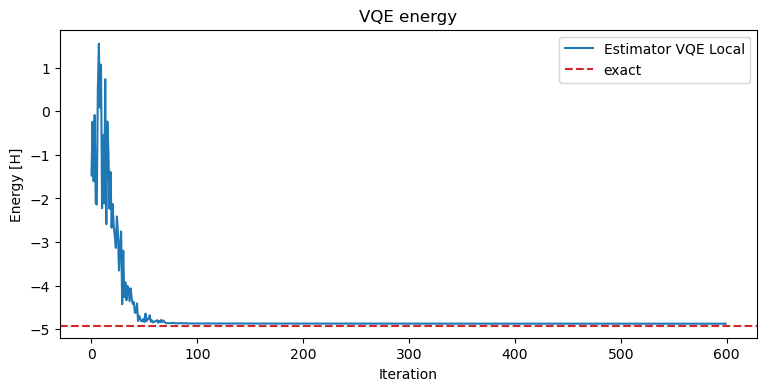

In [ ]:
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

Recycling the optimization

In [ ]:
optimal_point = result.optimal_point

#recycling again

In [ ]:
log = VQELog([], [])
vqe = VQE(estimator=estimator,
          ansatz=ansatz_hva,
          optimizer=COBYLA(maxiter=400,rhobeg=0.05),
          initial_point=optimal_point,
          callback=log.update)
result_rec = vqe.compute_minimum_eigenvalue(cost_operator)

In [ ]:
result_rec.eigenvalue


-4.9136006170136435

In [ ]:
result_rec.eigenvalue/exact_result.eigenvalue

0.9965973973945956

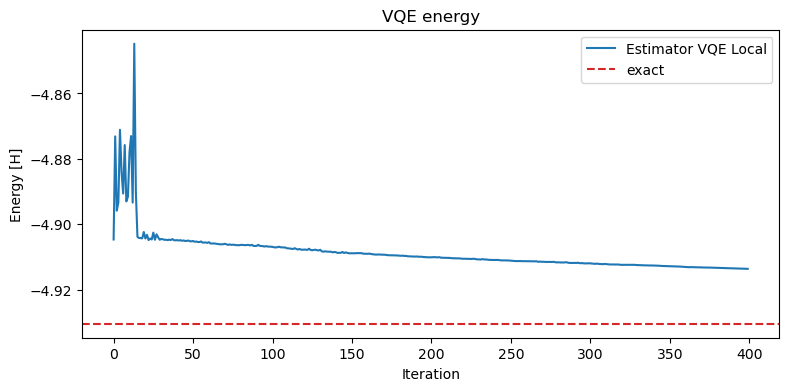

In [ ]:
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

## Hardware effficient Ansatz

### Noiseless

In [72]:
log = VQELog([], [])
counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

p_hea = 1
# ansatz_hea = EfficientSU2(num_qubits=len(graph.nodes),
#                           su2_gates='ry',
#                           reps=p_hea
#                           )
theta_list = ParameterVector('θ',2*n_qubits*p_hea)
ansatz_hea = get_ansatz_hea_ibm(graph,theta_list)
random_point = np.random.random(ansatz_hea.num_parameters)
ones_point = np.ones(ansatz_hea.num_parameters)
bfgs = L_BFGS_B()
cobyla = COBYLA(100)
spsa = SPSA(maxiter=300,trust_region=True,learning_rate=0.085,perturbation=0.1)
vqe = VQE(estimator=estimator,
          ansatz=ansatz_hea,
          optimizer=spsa,
          initial_point=ones_point,
          callback=log.update)
result_hea = vqe.compute_minimum_eigenvalue(cost_operator,aux_operators=[mag_op,kk_op])

In [73]:
def cost_function_vqe(theta):
    job = estimator.run(ansatz_hea, cost_operator, theta)
    values = job.result().values

    return values[0]

In [74]:
spsa = SPSA(maxiter=300,
            trust_region=True,
            learning_rate=0.085,
            perturbation=0.1)
result = spsa.minimize(fun=cost_function_vqe,
              x0=np.ones(ansatz_hea.num_parameters))

In [28]:
result_hea.optimal_point

array([ 1.06689503,  1.42253032,  1.11606701,  1.58027431,  1.81225009,
        0.56826923, -0.40572556, -1.33321653])

In [76]:
result.fun

-5.097513239565763

In [45]:
cost_function_vqe(result_hea.optimal_point)

array([-5.09694094])

0.9954272900856243


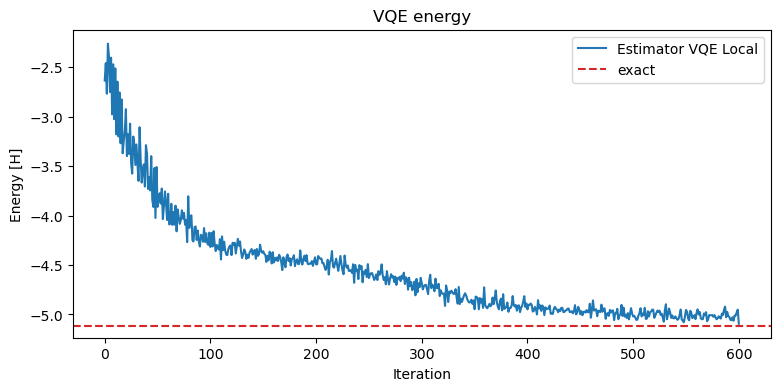

In [23]:
print(result_hea.eigenvalue/exact_result.eigenvalue)
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [24]:
result_hea.eigenvalue,result_hea.eigenvalue/exact_result.eigenvalue

(-5.093864457227218, 0.9954272900856243)

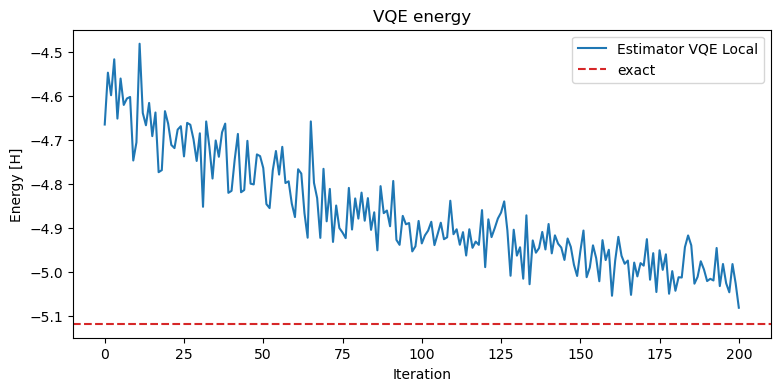

In [234]:
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [231]:
opt_point = result_hea.optimal_point

### Nairobi AER

In [298]:
device = FakeNairobi()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

In [30]:
noise_model

<NoiseModel on ['sx', 'id', 'reset', 'x', 'measure', 'cx']>

In [299]:
shots = 2**14
seed = 170

noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": shots},
    transpile_options={"seed_transpiler": seed},
)

In [300]:
log = VQELog([], [])

p_hea = 1

random_point = np.random.random(ansatz_hea.num_parameters)
bfgs = L_BFGS_B(600)
cobyla = COBYLA(400)
spsa = SPSA(maxiter=150,trust_region=True,learning_rate=0.085,perturbation=0.1)

vqe = VQE(estimator=noisy_estimator,
          ansatz=ansatz_hea,
          optimizer=spsa,
          initial_point=random_point,
          callback=log.update)
result_hea_noisy = vqe.compute_minimum_eigenvalue(cost_operator,aux_operators=[kk_op])

KeyboardInterrupt: 

In [34]:
result_hea_noisy.eigenvalue,result_hea_noisy.eigenvalue/exact_result.eigenvalue

(-3.385414173572799, 0.9178545708598203)

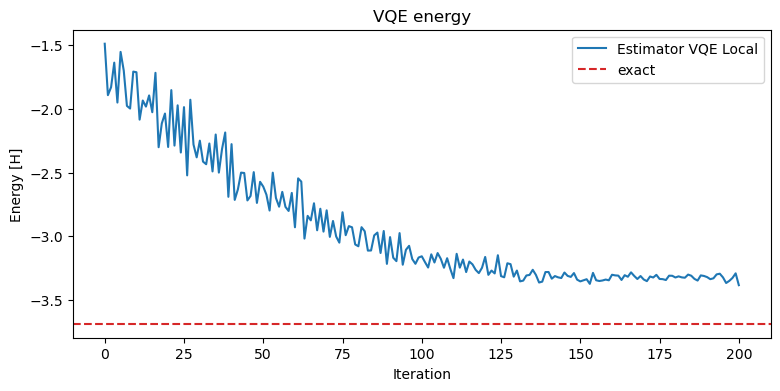

In [35]:
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [301]:
def get_ZNE_result_aer(n_qubits,
                   layers,
                   ap,
                   estimator,
                   optimizer,
                   initial_point,
                   shots=2**14):
    """Gets the vqe result by employing the ZNE method"""
    graph = get_line_graph(n_qubits)
    cost_operator = get_h_op(graph,ap=ap,hx=0.5)
    mag_op = get_mag_op(graph)
    kk_op = get_kk_op(graph)
    aux_operators = [mag_op,kk_op]
    theta_list = ParameterVector('θ',2*n_qubits*layers)
    ansatz_hea = get_ansatz_hea_ibm(graph,theta_list)
    ansatz_hea_k2 = get_ansatz_hea_ibm_ZNE(graph,theta_list)
    
    # k = 1 result
    vqe = VQE(estimator=estimator,
            ansatz=ansatz_hea,
            optimizer=optimizer,
            initial_point=initial_point)
    result_k1 = vqe.compute_minimum_eigenvalue(cost_operator,aux_operators=aux_operators)

    # k = 2 result
    vqe = VQE(estimator=estimator,
            ansatz=ansatz_hea_k2,
            optimizer=optimizer,
            initial_point=initial_point)
    result_k2 = vqe.compute_minimum_eigenvalue(cost_operator,aux_operators=aux_operators)

    return result_k1,result_k2
    

In [303]:
r1,r2 = get_ZNE_result_aer(4,1,ap,noisy_estimator,spsa,random_point)

In [307]:
r2.eigenvalue

-4.50555419921875

### Runtime

In [87]:
# Save an IBM Quantum account.
service = QiskitRuntimeService()
#service.save_account(channel="ibm_quantum", token="bbe37df5115273fe795d0cab351b2189aa8acd4889b464ccf2c2c8a22223b05a910d88d7294fd067c52e9997b898b88720022b14fdf7efe9ddc8d7c3afaf9ea7",overwrite=True)
backend = service.backend("ibmq_qasm_simulator")

In [90]:
service.least_busy(operational=True,simulator=False)

<IBMBackend('ibm_brisbane')>

In [55]:
quantum_backend = service.least_busy(operational=True,simulator=False)

In [88]:
p_hea = 1
theta_list = ParameterVector('θ',2*n_qubits*p_hea)
ansatz_hea = get_ansatz_hea_ibm(graph,theta_list)
ansatz_hea_k2 = get_ansatz_hea_ibm_ZNE(graph,theta_list)

random_point = np.random.random(ansatz_hea.num_parameters)
bfgs = L_BFGS_B(40)
cobyla = COBYLA(maxiter=5,rhobeg=0.1)
spsa = SPSA(maxiter=100,trust_region=True,learning_rate=0.085,perturbation=0.1)

options = options_mitigated_nairobi

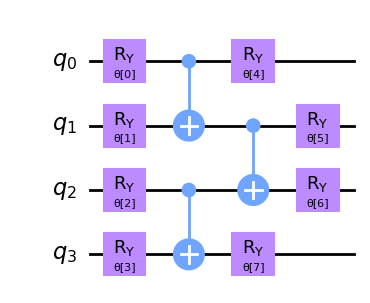

In [65]:
ansatz_hea.draw('mpl')

In [91]:
log = VQELog([], [])
with Session(service=service, backend=backend) as session:
    estimator_rtm = IBM_Estimator(session=session,
                                  options=options)
    vqe_k1 = VQE(estimator=estimator_rtm,
                 ansatz=ansatz_hea,
                 optimizer=spsa,
                 initial_point=opt_point,
                 callback=log.update)
    
    r1 = vqe_k1.compute_minimum_eigenvalue(operator=cost_operator,
                                        aux_operators=aux_operators)
    
    
    vqe_k2 = VQE(estimator=estimator_rtm,
                 ansatz=ansatz_hea_k2,
                 optimizer=spsa,
                 initial_point=opt_point)
    r2 = vqe_k2.compute_minimum_eigenvalue(operator=cost_operator,
                                        aux_operators=aux_operators)
    linear_extrap, exp_extrap = get_extrapolation(r1.eigenvalue,r2.eigenvalue) 
    

    session.close()

AlgorithmError: 'The primitive job to evaluate the energy failed!'

In [80]:
r1.eigenvalue/exact_result.eigenvalue,exp_extrap/exact_result.eigenvalue,linear_extrap/exact_result.eigenvalue

(0.9699858007874572, 0.9912280709885563, 0.9907728437240112)

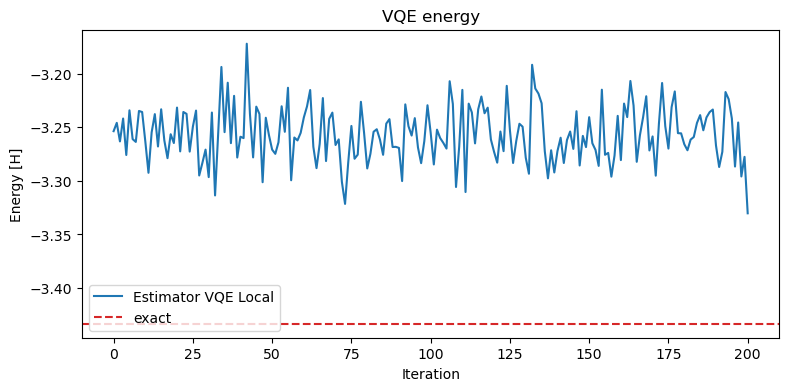

In [79]:
# Plot energy and reference value
plt.figure(figsize=(9, 4))
plt.plot(log.values, label="Estimator VQE Local")
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="exact")
#plt.axhline(y=-3.706, color="tab:blue", ls="--", label="qasm")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [89]:
with Session(service=service, backend=backend) as session:
    r1,r2 = get_ZNE_result(n_qubits=4,
                        layers=1,
                        ap=1.5,
                        session=session,
                        options=options_noisy_nairobi,
                        initial_point=random_point,
                        optimizer=SPSA(maxiter=2,trust_region=True,learning_rate=0.085,perturbation=0.1)
                        )

    session.close()


In [93]:
r2.eigenvalue

-2.4934549505800456

In [318]:
from scipy.optimize import curve_fit

In [326]:
def get_extrapolation(value_k1,value_k2):
    """Returns the exponential extrapolation given the 
    values for k=1 and k=2 noise factors"""
    k_values = [1.,2.]
    y_values = [value_k1/value_k2,1.0]

    # Fit a linear regression model (polynomial of degree 1)
    coefficients = np.polyfit(k_values, y_values, 1)

    # The coefficients represent the slope (m) and y-intercept (b) of the line
    slope, intercept = coefficients

    linear_extrapolation = intercept*value_k2

    ln_y = np.log(y_values)

    # Fit a linear regression model (polynomial of degree 1)
    coefficients_exp = np.polyfit(k_values, ln_y, 1)

    # The coefficients represent the slope (m) and y-intercept (b) of the line
    slope_exp, intercept_exp = coefficients_exp

    exp_extrapolation = np.exp(intercept_exp)*value_k2

    # Define the exponential function
    # def exponential_func(x, a, b):
    #     return a * np.exp(b * x)
    
    # params, covariance = curve_fit(exponential_func, k_values, y_values)
    # a_opt, b_opt = params

    # exp_extrapolation = a_opt*value_k2
    

    
    # plt.plot([1.,2.],[value_k1,value_k2],'ro')
    # plt.plot([0,1.,2.],[linear_extrapolation,value_k1,value_k2],label='linear')
    # plt.plot([0,1.,2.],[exp_extrapolation,value_k1,value_k2],label='exponential')
    # plt.legend()
    
    return linear_extrapolation,exp_extrapolation

In [312]:
x_data = np.linspace(1,5,20)
y_data = 2*np.exp(0.5*x_data)

In [313]:
ln_x = np.log(x_data)
ln_y = np.log(y_data)

In [261]:
# Fit a linear regression model (polynomial of degree 1)
coefficients_exp = np.polyfit(x_data, ln_y, 1)

# The coefficients represent the slope (m) and y-intercept (b) of the line
slope_exp, intercept_exp = coefficients_exp

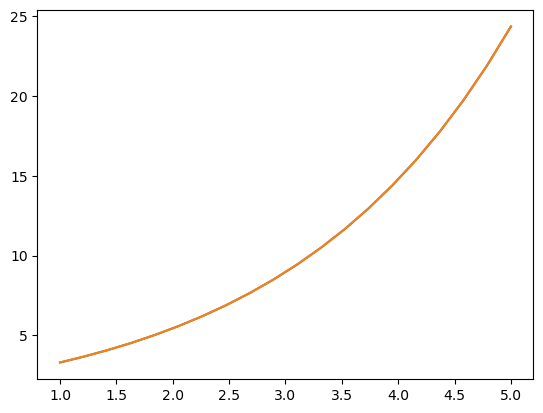

In [262]:
plt.plot(x_data,y_data)
plt.plot(x_data,np.exp(intercept_exp)*np.exp(slope_exp*x_data))

(-4.624938964843751, -4.625729806637742)

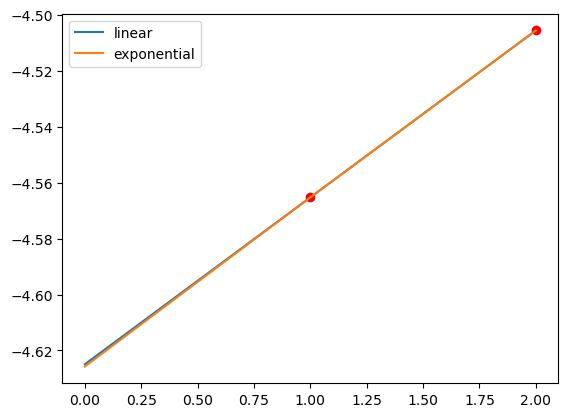

In [327]:
get_extrapolation(r1.eigenvalue,r2.eigenvalue)

Recycling

In [ ]:
optimal_point = result_hea.optimal_point
optimal_circuit = ansatz_hea.bind_parameters(optimal_point)

In [ ]:
result = estimator.run(optimal_circuit,cost_operator).result()

In [ ]:
result.values,result.values/exact_result.eigenvalue

(array([-4.20697898]), array([0.99661282]))

In [ ]:
with Session(service,backend) as session:
    estimator_rtm = IBM_Estimator(session=session,
                                  options=options_mitigated_nairobi)
    result_rtm = estimator_rtm.run(optimal_circuit,cost_operator).result()
    session.close()

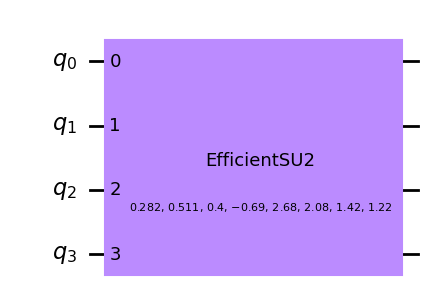

In [ ]:
optimal_circuit.draw('mpl')

In [ ]:
result_rtm.values,result_rtm.values/exact_result.eigenvalue

(array([-3.91787923]), array([0.9281265]))

In [ ]:
values = result_rtm.metadata[0]['zne']['noise_amplification']['values']

In [ ]:
values

[-3.9212646484375, -3.91622314453125, -3.91395263671875]

In [ ]:
noise_factors = result_rtm.metadata[0]['zne']['noise_amplification']['noise_factors']

In [ ]:
result_rtm.metadata

[{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
    'noise_factors': [1, 2, 3],
    'values': [-3.9212646484375, -3.91622314453125, -3.91395263671875],
    'variance': [4.169829561188817, 4.184890594035387, 4.183562869206071],
    'shots': [32768, 32768, 32768]},
   'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}]

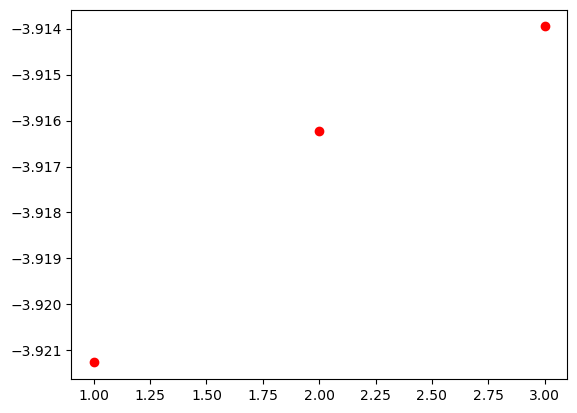

In [ ]:
plt.plot(noise_factors,values,'ro')
#plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--")

## Trotter evolution

In [139]:
def get_trotter_antip(graph,ap=1.25,h=0.5,steps=5,dt=1e-2):
    
    n_qubits = len(graph.nodes)
    trotter_circ = QuantumCircuit(n_qubits)
    circ_list = []
    
    #initial state
    trotter_circ.h(range(n_qubits))

    for step in range(steps):
        x_angle = -2*(1-step/steps)*dt
        z_angle = -2*(step/steps)*dt
        # interaction hamiltonian
        for pair in graph.edges:
            trotter_circ.rzz(z_angle,pair[0],pair[1])
        trotter_circ.rz(-1*z_angle*ap,0)
        trotter_circ.rz(z_angle*ap,n_qubits-1)
        # mixing + transverse field
        trotter_circ.rx(x_angle+z_angle*h,range(n_qubits))
        
        circ_list.append(trotter_circ.copy())
    
    return circ_list


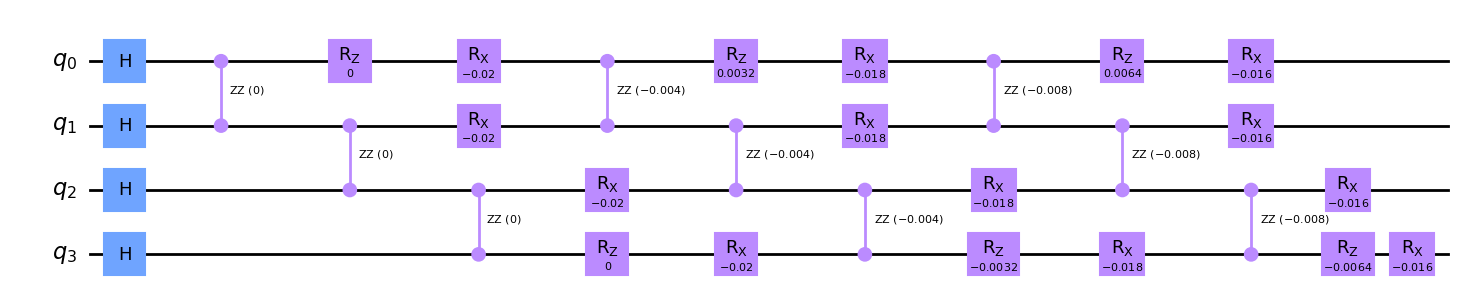

In [140]:
get_trotter_antip(graph,ap=ap,steps=5)[2].draw('mpl')

In [141]:
dt = 2e-2
steps = 600
dt*steps
T = dt*steps
T

12.0

In [142]:
shots = 2**15
estimator = Estimator(options={'shots':shots,'seed':120})
trotter_circ_antip = get_trotter_antip(graph,steps=steps,ap=ap,dt=dt)[-1]
#trotter_circ.draw('mpl')
result_trotter_antip = estimator.run(trotter_circ_antip,cost_operator).result()

In [143]:
result_trotter_antip.values

array([-3.78646835])

In [144]:
time_instants = np.linspace(dt,steps*dt,steps)
H_d = get_h_op(graph,hx=1,J=0).simplify()
H_p = get_h_op(graph,hx=0.5,ap=ap).simplify()

#making the time-depedent hamiltonian
H_t = []
for t in time_instants:
    H_t.append((1-t/T)*H_d+(t/T)*H_p)

In [145]:
steps_circuits = get_trotter_antip(graph,steps=steps,ap=ap,dt=dt)
trotter_ev = estimator.run(steps_circuits,H_t).result()

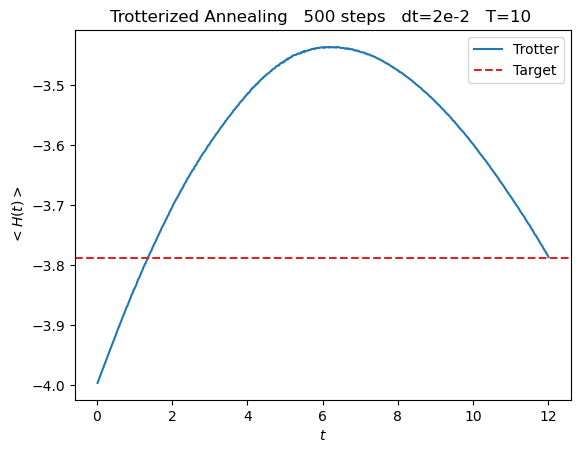

In [146]:
plt.plot(time_instants,trotter_ev.values,label='Trotter')
plt.axhline(y=exact_result.eigenvalue, color="tab:red", ls="--", label="Target")
plt.title('Trotterized Annealing   500 steps   dt=2e-2   T=10 ')
plt.ylabel("$< H(t) >$")
plt.xlabel("$t$")

plt.legend(loc="best")

In [ ]:
# estimator = Estimator(options={'shots':2**14,'seed':170})
# optimizers = [L_BFGS_B(maxiter=80), SLSQP(maxiter=150),QNSPSA(maxiter=100,fidelity=fidelity,resamplings=20)]
# converge_counts = np.empty([len(optimizers)], dtype=object)
# converge_vals = np.empty([len(optimizers)], dtype=object)

# for i, optimizer in enumerate(optimizers):
#     print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
#     algorithm_globals.random_seed = 50
#     ansatz = get_ansatz_antiparallel(graph,theta_list_c)

#     counts = []
#     values = []

#     def store_intermediate_result(eval_count, parameters, mean, std):
#         counts.append(eval_count)
#         values.append(mean)

#     vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
#     result = vqe.compute_minimum_eigenvalue(cost_operator)
#     converge_counts[i] = np.asarray(counts)
#     converge_vals[i] = np.asarray(values)

# print("\rOptimization complete      ");

In [ ]:
# f,ax = plt.subplots()
# for i, optimizer in enumerate(optimizers):
#     plt.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
# plt.xlabel("Eval count")
# plt.ylabel("Energy")
# plt.title("Energy convergence for various optimizers")
# plt.axhline(y=exact_ec_4q, color='red', linestyle='dashed')
# plt.xlim([0.,300])
# plt.legend(loc="upper right");

In [ ]:
# estimator = Estimator(options={'shots':2**14,'seed':170})
# resampled_energy = 0.
# optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
# converge_counts = np.empty([len(optimizers)], dtype=object)
# converge_vals = np.empty([len(optimizers)], dtype=object)
# reps=1
# optimizer = L_BFGS_B()
# for i in range(reps):
#     initial_point = np.random.random(ansatz_c.num_parameters)
#     vqe = VQE(estimator=estimator,ansatz=ansatz_c,
#                 optimizer=optimizer,initial_point=initial_point)
#     sample_result = vqe.compute_minimum_eigenvalue(operator=cost_operator,
#                                                 aux_operators=aux_operators)
#     eigenvalue = sample_result.eigenvalue
    
#     if eigenvalue < resampled_energy:
#         resampled_energy = eigenvalue
#         result = sample_result

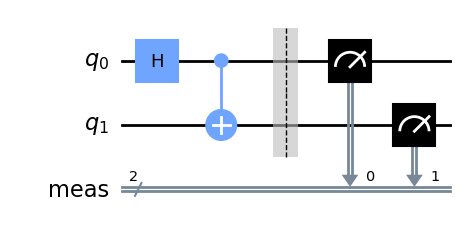

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cnot(0,1)
qc.draw('mpl')
qc.measure_all()
qc.draw('mpl')


In [ ]:
op = SparsePauliOp('XI')

In [ ]:
est = Sampler()
result = est.run(qc)

In [ ]:
result.result().quasi_dists

[{0: 0.4999999999999999, 3: 0.4999999999999999}]

Optimal

In [ ]:
optimal_parameters = angles_4q_ap_bfgs_p3['0.8125']
optimal_circuit = ansatz_c.bind_parameters(optimal_parameters)

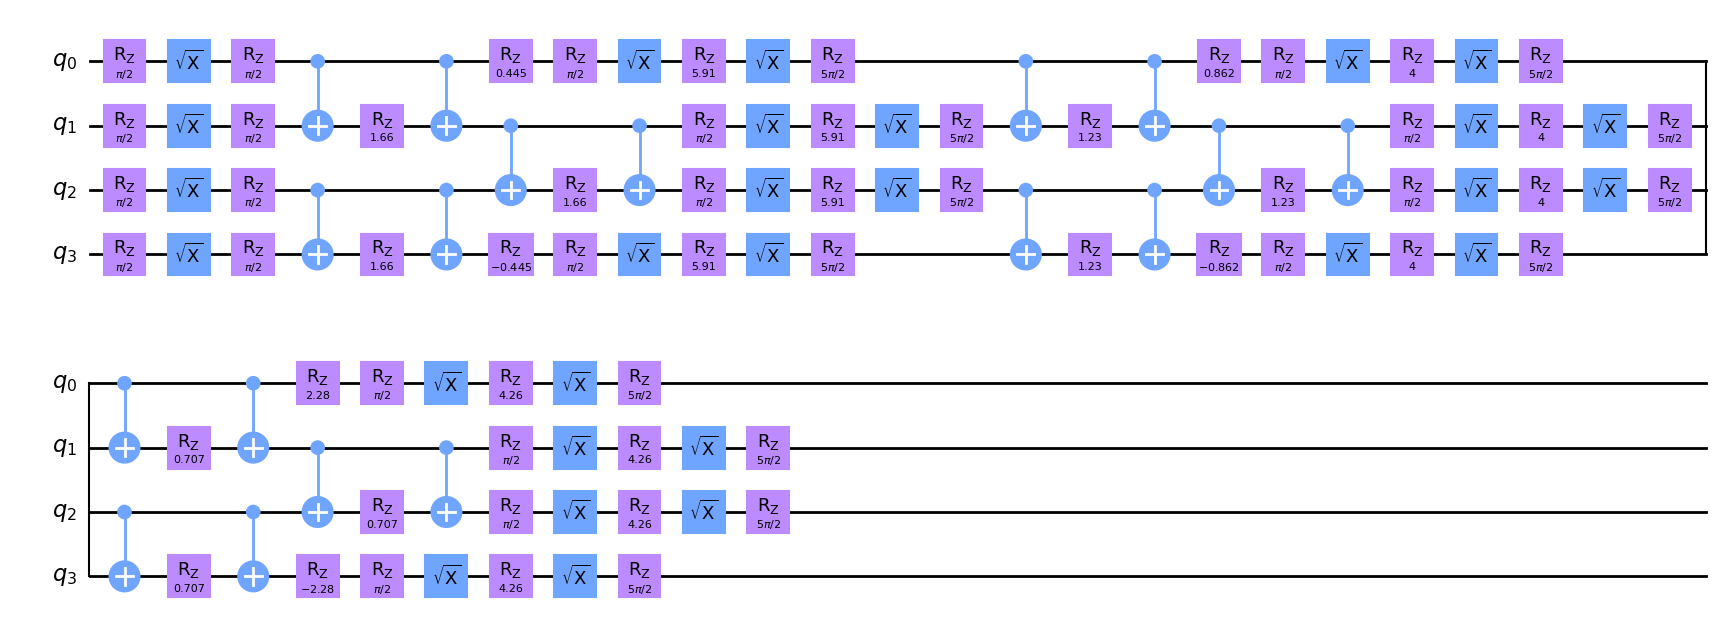

In [ ]:
optimal_circuit.draw('mpl')

Using standart primitives

In [ ]:
shots = 2**14
estimator = Estimator(options={'shots':shots})
job = estimator.run(optimal_circuit,cost_operator)

In [ ]:
job.result()

EstimatorResult(values=array([-3.80281492]), metadata=[{'variance': 0.0031090871401779907, 'shots': 16384}])

In [ ]:
job.result().values

array([-3.80281492])

Now using IBMQ QASM

In [ ]:
options_exct = Options()
options_exct.execution.shots = shots

In [ ]:
service.backends()

[<IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_belem')>]

In [ ]:
fake_backend = FakeNairobi()
noise_model = NoiseModel().from_backend(fake_backend)
options_noisy = Options()
options_noisy.execution.shots = shots
options_noisy.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_noisy.optimization_level = 3 # no optimization
options_noisy.resilience_level = 2 # M3 for Sampler and T-REx for Estimator

In [ ]:
#Running without noise

# with Session(service=service, backend=backend) as session:
#     estimator = IBM_Estimator(session=session,options=options_exct)
#     job = estimator.run(optimal_circuit, cost_operator)
#     result_exct = job.result()
#     # Close the session only if all jobs are finished, and you don't need to run more in the session
#     session.close()

# print(result_exct)

In [ ]:
#Running with noise

# with Session(service=service, backend=backend) as session:
#     estimator = IBM_Estimator(session=session,options=options_noisy)
#     job = estimator.run(optimal_circuit, cost_operator)
#     result = job.result()
#     # Close the session only if all jobs are finished, and you don't need to run more in the session
#     session.close()

# Circuit drawing

4 qubits

In [ ]:
p=4
param_p4 = [Parameter(r'$\theta_{'+str(i+1)+'}$') for i in range(3*p)]

In [ ]:
large_font = {
    "fontsize": 12,
    "subfontsize": 11,
    "displaycolor": {
        "rz":'#6fdc8c'
    },
}


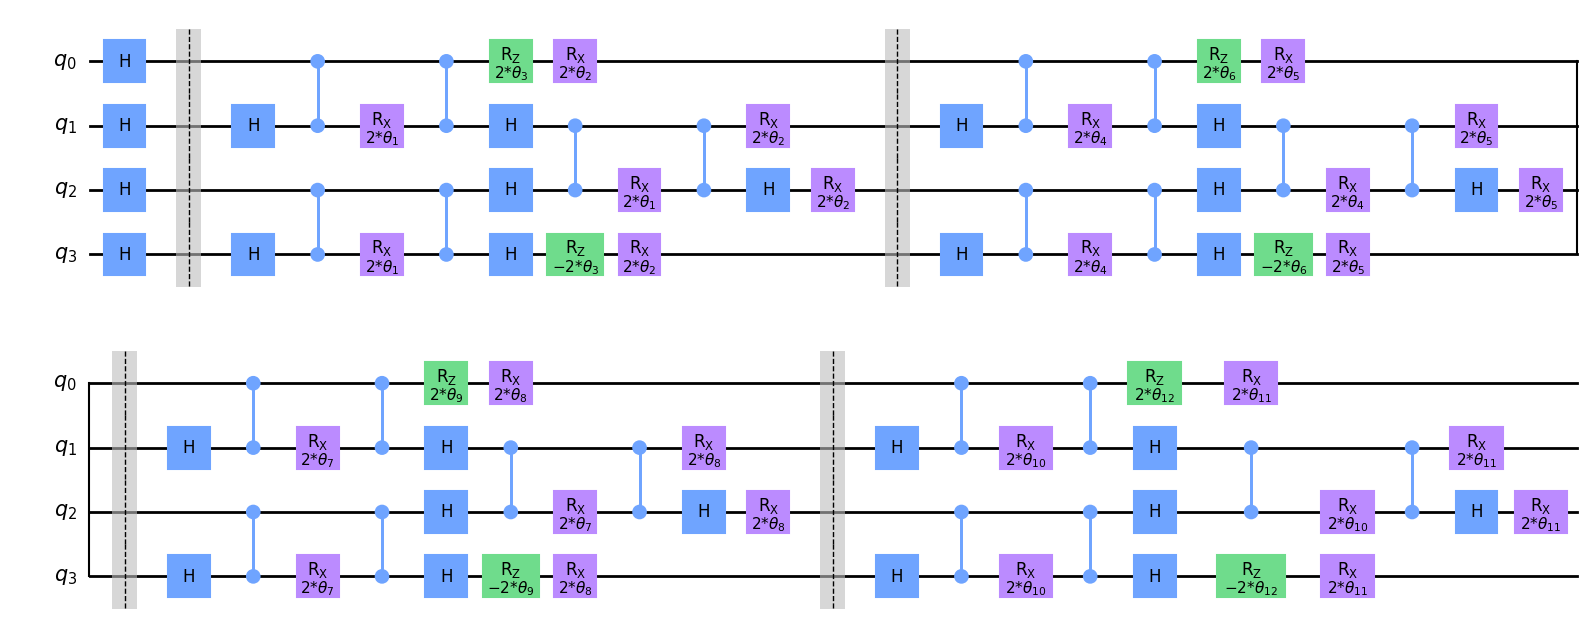

In [ ]:
qc = get_ansatz_antiparallel(graph,param_p4)
qc.draw('mpl',filename='/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/circuit_4q_p4',fold=23,vertical_compression='high',style=large_font)

6 qubits

In [ ]:
p=6
param_p6 = [Parameter(r'$\theta_{'+str(i+1)+'}$') for i in range(3*p)]

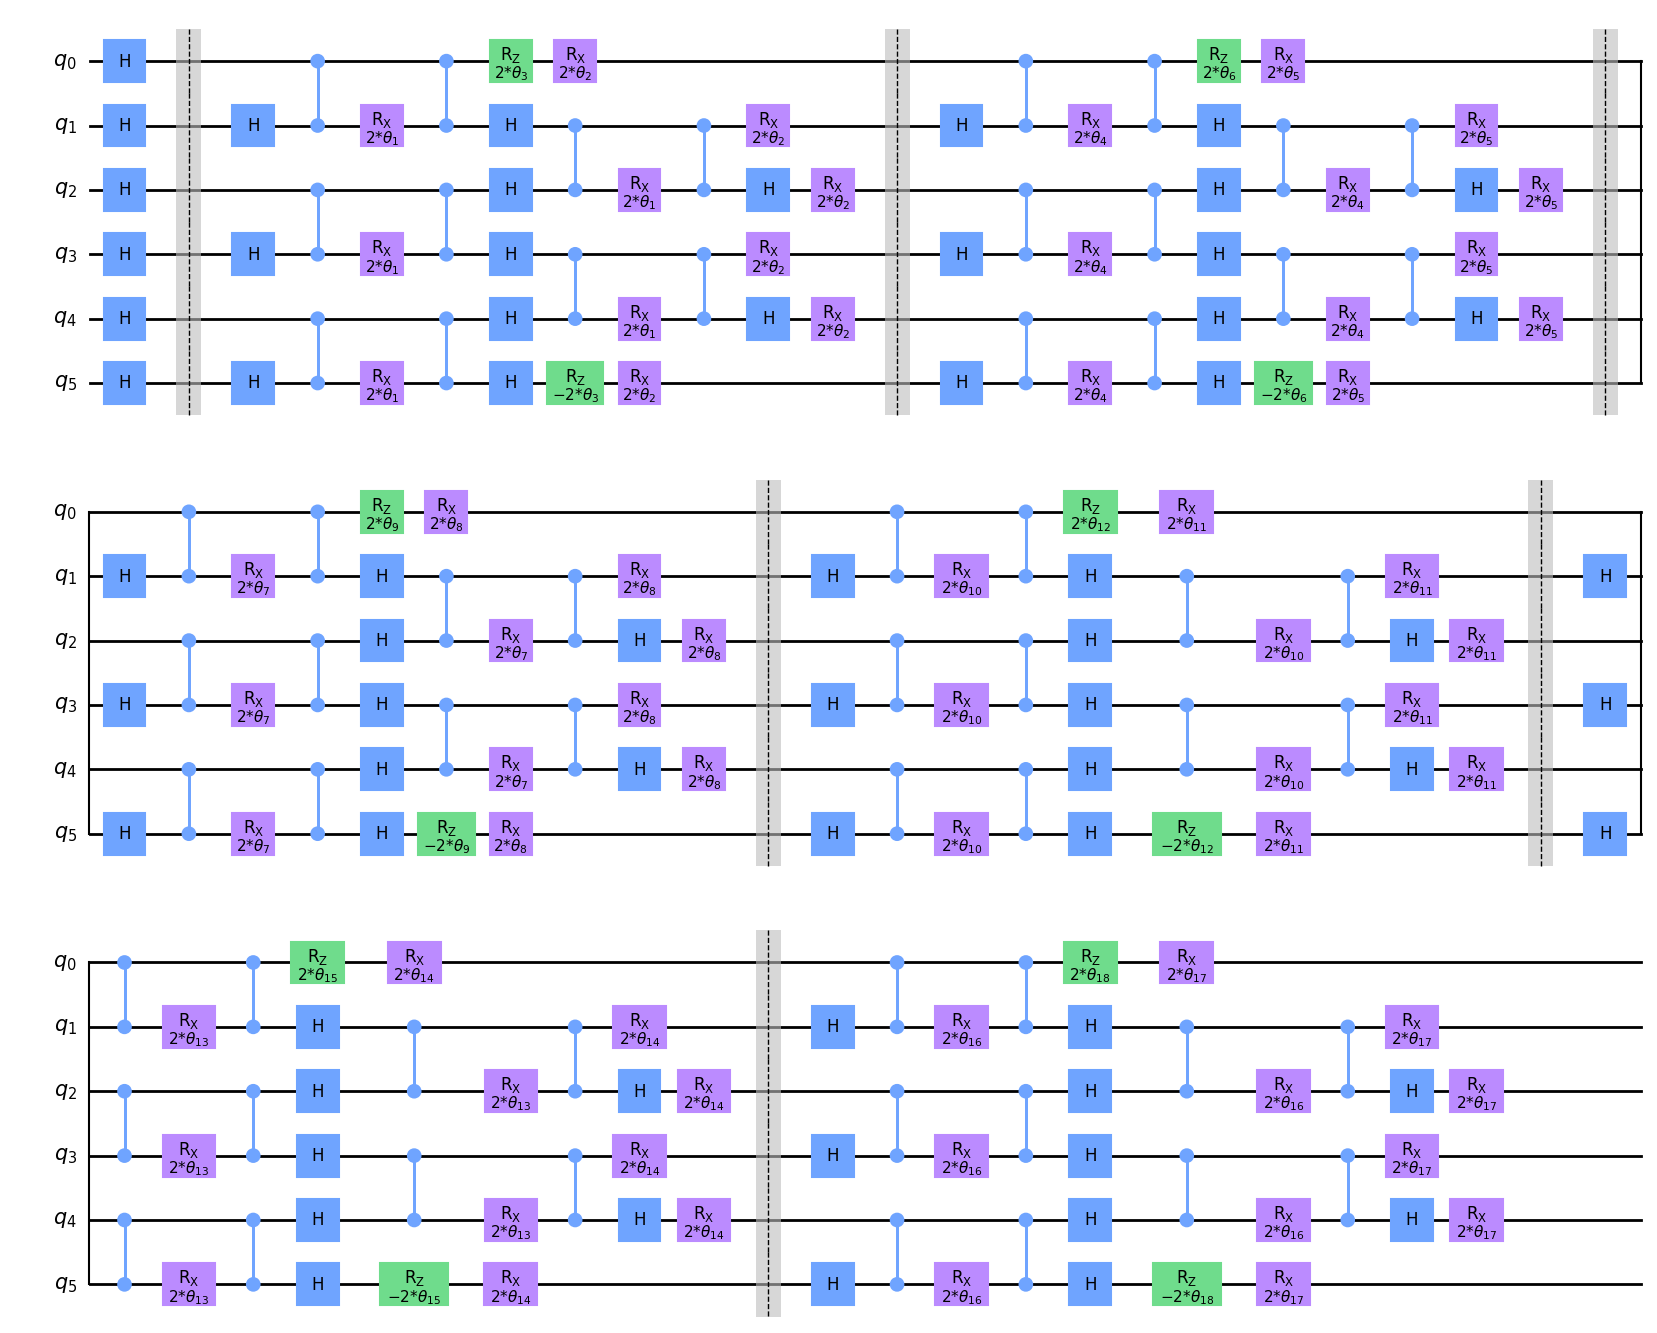

In [ ]:
qc = get_ansatz_antiparallel(graph_6q_ol,param_p6)
qc.draw('mpl',filename='/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/circuit_6q_p6',fold=24,style=large_font)

8 qubits

In [ ]:
p=9
param_p9 = [Parameter(r'$\theta_{'+str(i+1)+'}$') for i in range(3*p)]

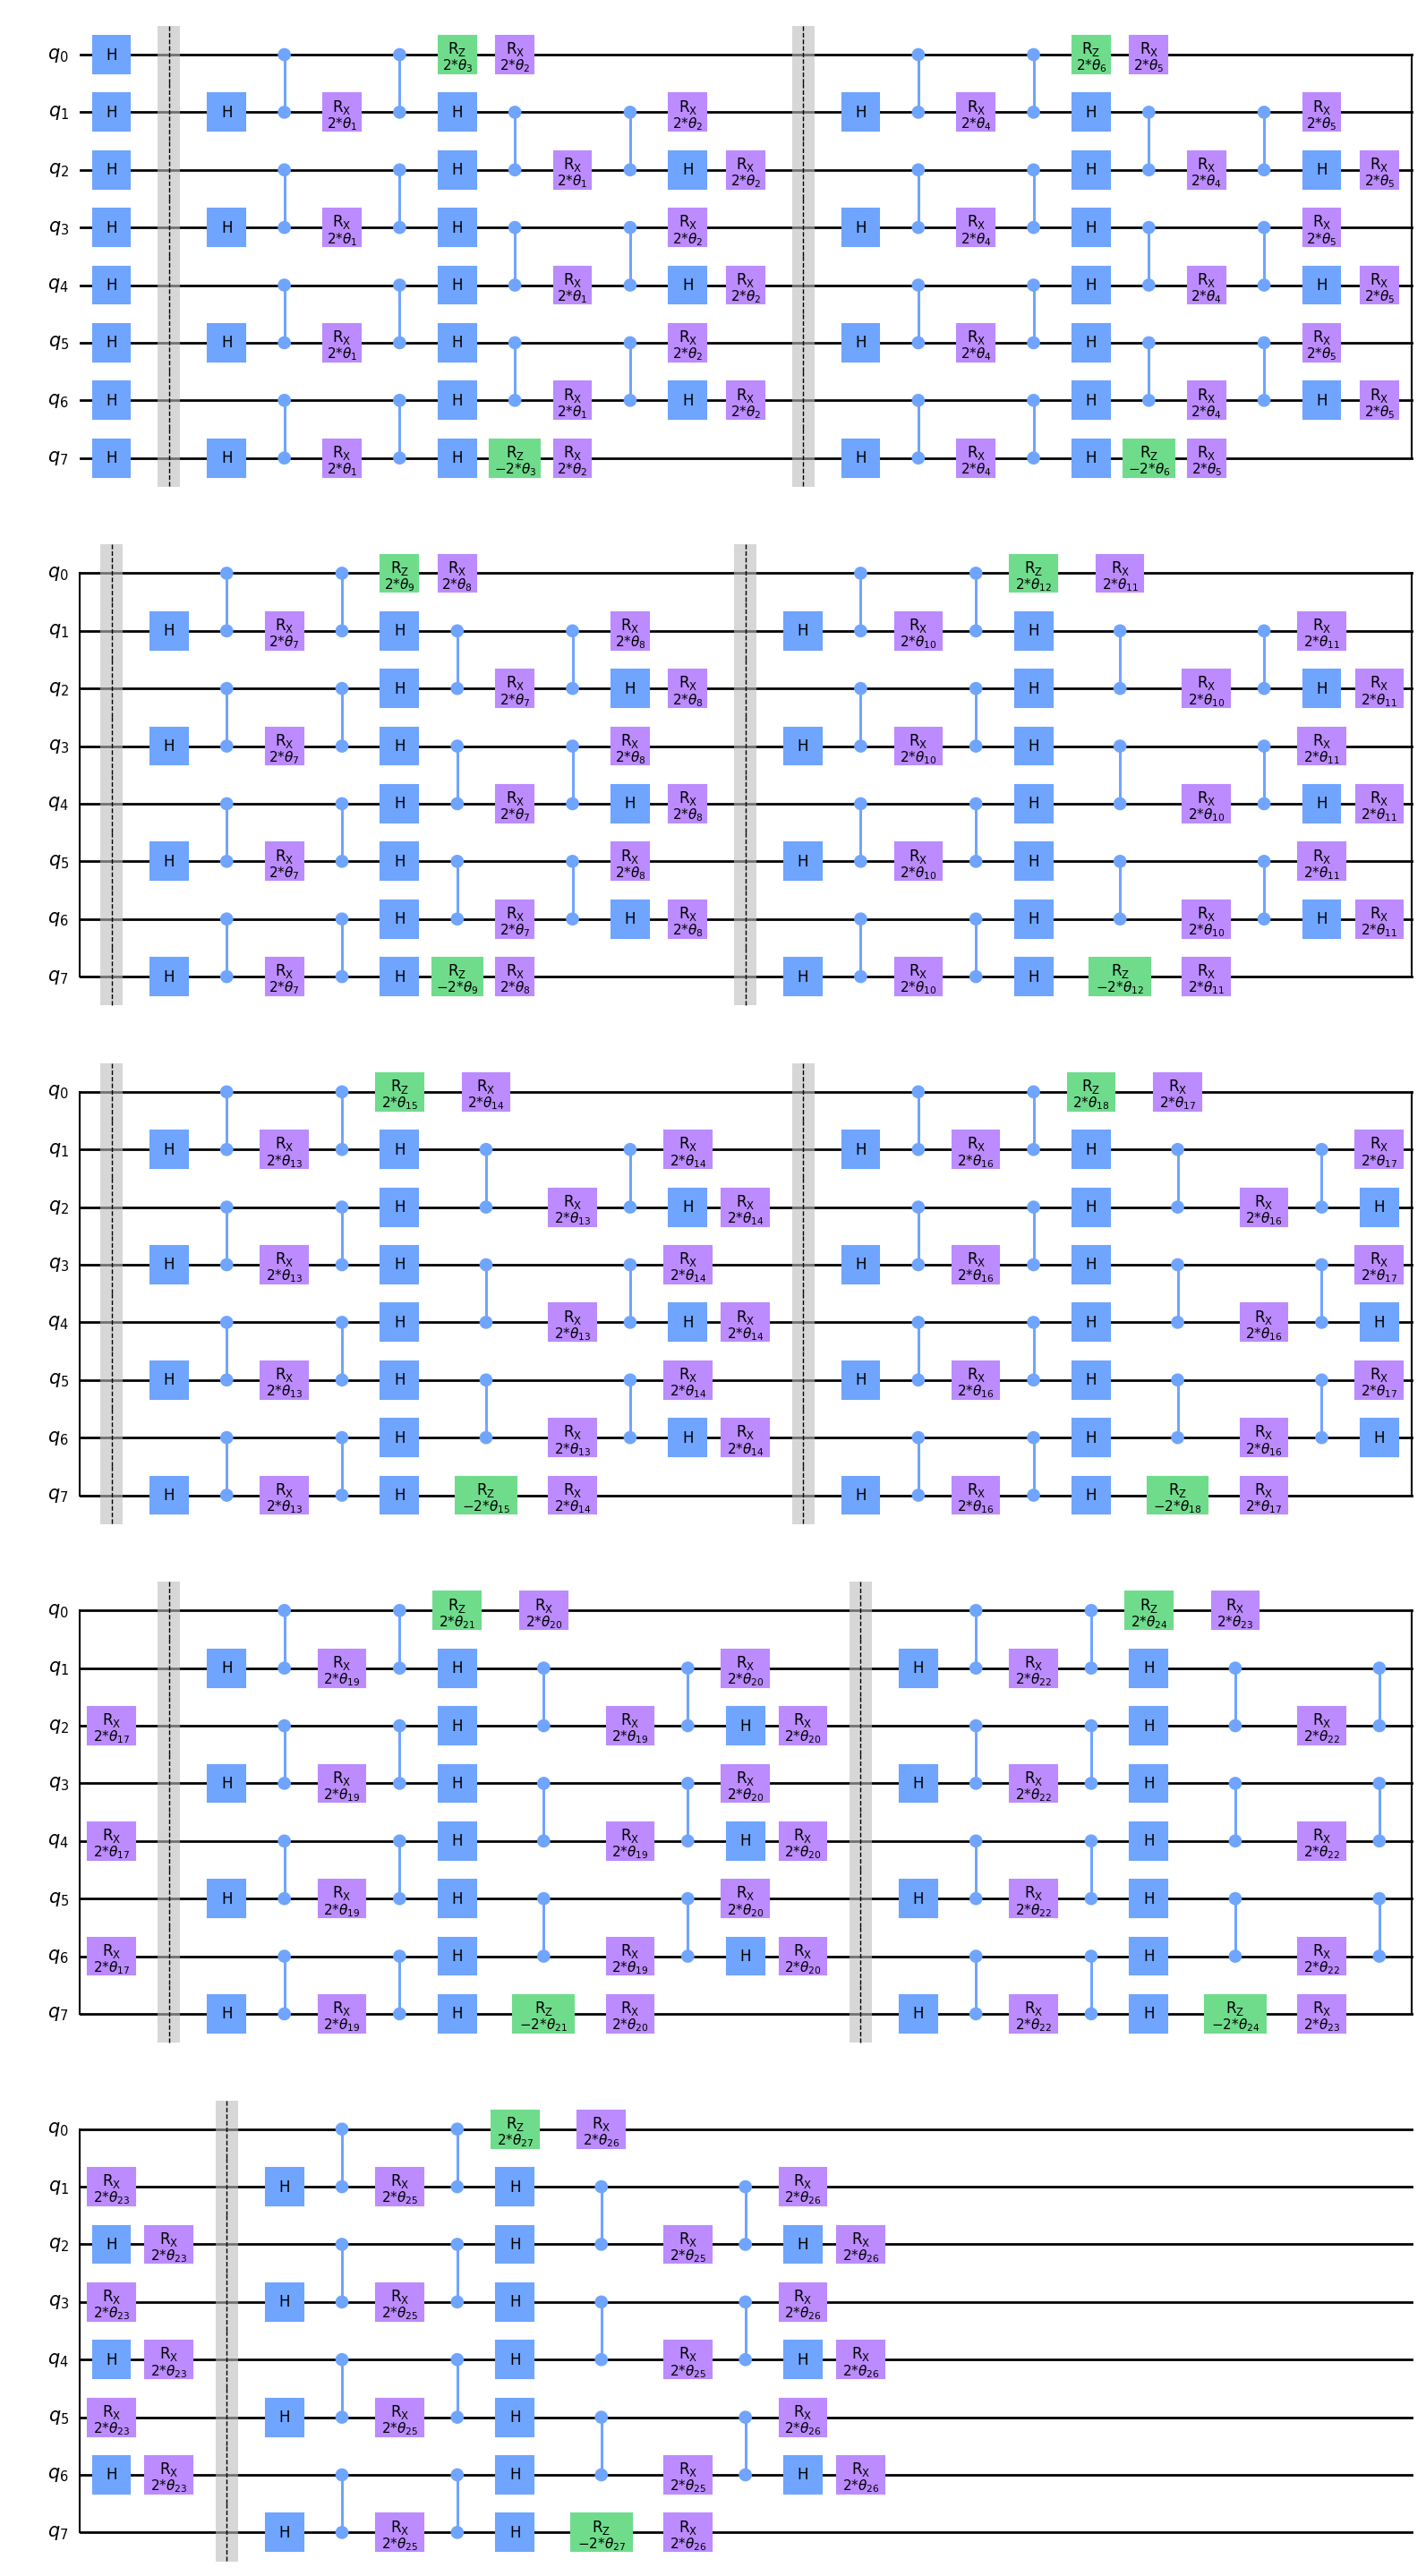

In [ ]:
qc = get_ansatz_antiparallel(graph_8q_ol,param_p9)
qc.draw('mpl',filename='/home/alan/Desktop/Projects/Python/qu_engine_std/Simulations/circuit_8q_p9',fold=23,style=large_font)

p=6
param_p6 = [Parameter(r'$\theta_{'+str(i+1)+'}$') for i in range(3*p)]

# Exact results

In [ ]:
E_8q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/E0-8.dat')
E_12q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/E0-12.dat')
E_16q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/E0-16.dat')

kk_8q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/kk-8.dat')
kk_12q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/kk-12.dat')
kk_16q_data = np.loadtxt('/home/alan/Desktop/Projects/Python/data/exact_data/kk-16.dat')

In [ ]:
g = E_8q_data[:,0]
E_8q = E_8q_data[:,1]
dg = np.diff(g)
dE = np.diff(E_8q)
de_1_8q = dE/dg
de_2_8q = np.diff(de_1_8q)/dg[:-1]

E_12q = E_12q_data[:,1]
dE = np.diff(E_12q)
de_1_12q = dE/dg
de_2_12q = np.diff(de_1_12q)/dg[:-1]

E_16q = E_16q_data[:,1]
dE = np.diff(E_16q)
de_1_16q = dE/dg
de_2_16q = np.diff(de_1_16q)/dg[:-1]

In [ ]:
ax.tick_params(axis='both', labelsize=12)  # Change the default size for all ticks
ax.tick_params(axis='both', which='major', labelsize=16)  # Change the size of major ticks
ax.tick_params(axis='both', which='minor', labelsize=8)

In [ ]:
def get_sparse_list(data):
    l = len(data)
    l_x = np.array([data[:,0][i] for i in range(1,l,18)])
    l_y = np.array([data[:,1][i] for i in range(1,l,18)])
    return [l_x,l_y]

In [ ]:
l = get_sparse_list(E_8q_data)

In [ ]:
E_8q_data[0]

array([ 0.01      , -7.64062203])

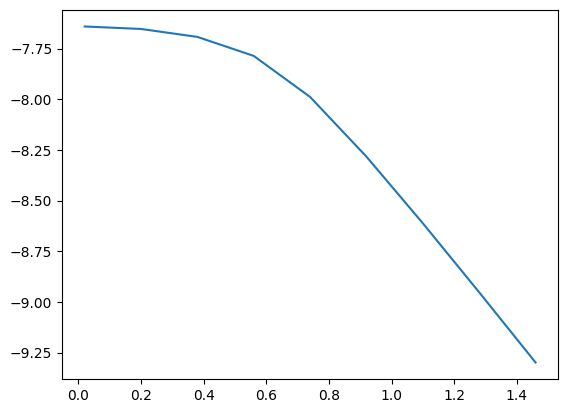

In [ ]:
f,ax = plt.subplots()
plt.plot(l[0],l[1])

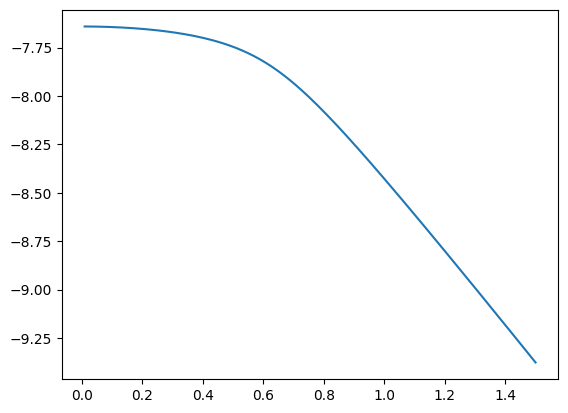

In [ ]:
plt.plot(E_8q_data[:,0],E_8q_data[:,1])

In [ ]:
def sps(l,step=7):
    sps_l = [l[i] for i in range(0,len(l),step)]
    return sps_l

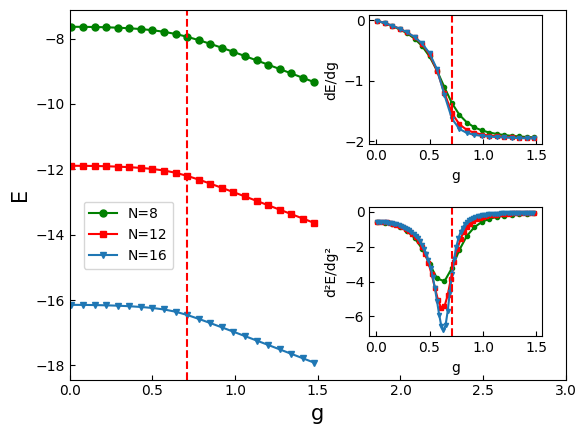

In [ ]:
markersize = 3

l_8 = get_sparse_list(E_8q_data)
l_12 = get_sparse_list(E_12q_data)
l_16 = get_sparse_list(E_16q_data)

f,ax = plt.subplots()
fontsize = 15
plt.plot(sps(E_8q_data[:,0]),sps(E_8q_data[:,1]),'go-',label='N=8',markersize=markersize+2)
plt.plot(sps(E_12q_data[:,0]),sps(E_12q_data[:,1]),'rs-',label='N=12',markersize=markersize+2)
plt.plot(sps(E_16q_data[:,0]),sps(E_16q_data[:,1]),'v-',label='N=16',markersize=markersize+2)
ax.set_xlim([0,3])
ax.tick_params(axis='both', direction='in', which='both')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('E',fontsize=fontsize)
plt.legend(loc=[0.028,0.3])
plt.axvline(x=np.sqrt(0.5), color='red', linestyle='dashed')

inset_ax = f.add_axes([0.593, 0.6, 0.27, 0.27])# [left, bottom, width, height]
inset_ax.plot(sps(g[:-1]),sps(de_1_8q),'go-',markersize=markersize)
inset_ax.plot(sps(g[:-1]),sps(de_1_12q),'rs-',markersize=markersize)
inset_ax.plot(sps(g[:-1]),sps(de_1_16q),'v-',markersize=markersize)
inset_ax.set_ylabel('dE/dg')
inset_ax.set_xlabel('g')
inset_ax.axvline(x=np.sqrt(0.5), color='red', linestyle='dashed')

inset_ax.tick_params(axis='both',direction='in') 
inset_ax = f.add_axes([0.593, 0.2, 0.27, 0.27])# [left, bottom, width, height]
inset_ax.plot(sps(g[:-2]),sps(de_2_8q),'go-',markersize=markersize)
inset_ax.plot(sps(g[:-2],step=3),sps(de_2_12q,step=3),'rs-',markersize=markersize)
inset_ax.plot(sps(g[:-2],step=2),sps(de_2_16q,step=2),'v-',markersize=markersize)
inset_ax.tick_params(axis='both', direction='in', which='both')
inset_ax.set_ylabel('d²E/dg²')
inset_ax.set_xlabel('g')
inset_ax.axvline(x=np.sqrt(0.5), color='red', linestyle='dashed')

plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/exact_results.pdf',format='pdf')



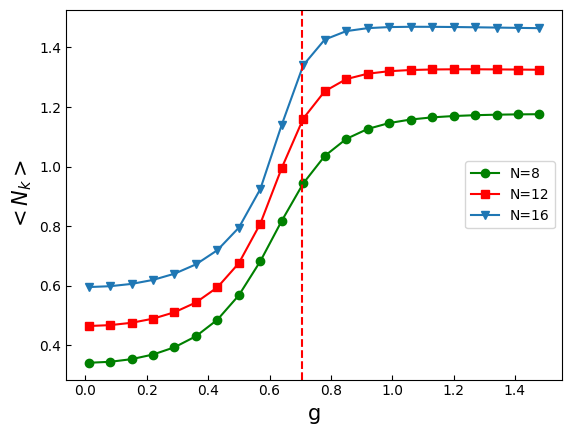

In [ ]:
f,ax = plt.subplots()
fontsize = 15
plt.plot(sps(kk_8q_data[:,0]),sps(kk_8q_data[:,1]),'go-',label='N=8')
plt.plot(sps(kk_12q_data[:,0]),sps(kk_12q_data[:,1]),'rs-',label='N=12')
plt.plot(sps(kk_16q_data[:,0]),sps(kk_16q_data[:,1]),'v-',label='N=16')
ax.tick_params(axis='both', direction='in', which='both')
plt.xlabel('g',fontsize=fontsize)
plt.ylabel('$<N_k>$',fontsize=fontsize)
plt.legend(loc='center right')
plt.axvline(x=np.sqrt(0.5), color='red', linestyle='dashed')
plt.savefig('/home/alan/Desktop/Projects/Python/qu_engine_std/Ising Simulations/figures/exact_kk_results.pdf',format='pdf')

In [ ]:
from qiskit.circuit.random import random_circuit

In [ ]:
circuit = QuantumCircuit(1)
circuit = random_circuit(2, 2, seed=0).decompose(reps=1)
observable = SparsePauliOp("XZ")
print(f">>> Observable: {observable.paulis}")

>>> Observable: ['XZ']


In [ ]:
estimator = IBM_Estimator(session=backend)

In [ ]:
job = estimator.run(circuit, observable)

In [ ]:
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

>>> EstimatorResult(values=array([0.5135]), metadata=[{'variance': 0.73631775, 'shots': 4000}])
  > Expectation value: 0.5135
  > Metadata: {'variance': 0.73631775, 'shots': 4000}


# MISC

In [ ]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")

Number of qubits: 2


In [ ]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


In [ ]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP,COBYLA,L_BFGS_B,QNSPSA,SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=30000)

In [ ]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [ ]:

from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed})

In [ ]:
# instantiate and run VQE
from qiskit.algorithms.minimum_eigensolvers import VQE

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)

KeyboardInterrupt: 

In [ ]:
dt=1e-5

Text(0.5, 1.0, 'Convergence with no noise')

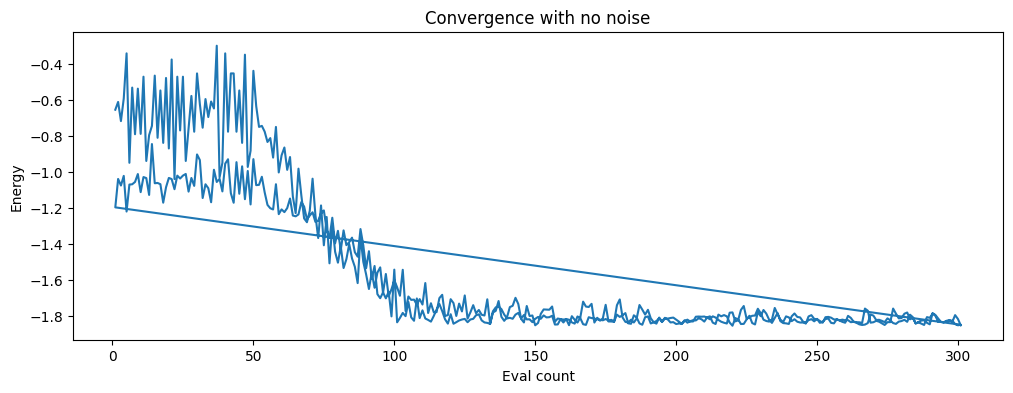

In [ ]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")